# 1. Özet

Bu çalışmada, farklı sektörlere ait şirketlerin zaman serisi verileri kullanılarak sektörel sınıflandırma yapılması amaçlanmıştır. Şirketlerin zaman içindeki kapanış fiyatları temel alınarak çeşitli teknikler uygulanmış ve hangi sektöre ait oldukları belirlenmeye çalışılmıştır.

Çalışma toplam 14 bölümden oluşmaktadır. İlk olarak gerekli veri seti oluşturulmuş, ardından veri üzerinde çeşitli düzenlemeler yapılmıştır. Yapılan denemeler sonucunda, veriye en uygun dönüşümün karekök dönüşümü olduğu belirlenmiş ve ardından robust scale yöntemi uygulanmıştır.

Verinin kategorik Symbol değerlerini kodlamak için farklı bir yöntem kullanılmış ve bu yöntem ilgili bölümde ayrıntılı olarak açıklanmıştır. Gerekli düzenlemeler yapıldıktan sonra, veri setinden öznitelik çıkarmak amacıyla tsfresh kütüphanesi kullanılmış ve birçok özellik otomatik olarak elde edilmiştir.

Bu süreç sonunda veriye sırasıyla eksik veri doldurma, özellik seçme, aykırı değer düzenleme ve boyut indirgeme adımları uygulanmıştır. Elde edilen son veri ile farklı makine öğrenimi modelleri eğitilmiş ve yüksek sınıflandırma başarıları elde edilmiştir.

Son olarak, Real Estate sektörüne ait şirket verileri model üzerinde test edilerek sektörel benzerlik analizi yapılmış ve sonuçlar paylaşılmıştır.

Ayrıca 3. bölümden itibaren tüm veri önişleme adımlarının hem manuel hem de pipeline yapıları kurgulanırken daha sonra tüm işlemler tek bir pipeline üzerinde birleştirilmiştir.

# 2. Veri Seti Oluşturma

## 2.1. Sektörlere ait Şirket Verilerini Hazırlama

Verileri elde etmek için gerekli yardımcı fonksiyonlar

In [120]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from io import StringIO

def fetch_sectors_names():
    url = "https://stockanalysis.com/stocks/industry/sectors/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(StringIO(str(soup.find_all("table"))))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

def fetch_data(sectors):
    url = f"https://stockanalysis.com/stocks/sector/{sectors}/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(StringIO(str(soup.find_all("table"))))[0]
        df.drop(columns='No.', inplace=True)
    else:
        print(f"Error: Failed to fetch data from page {url}")
        
    return df

Sektör bilgilerini inceleme

In [328]:
sectors=fetch_sectors_names()
sectors

,Sector Name,Stocks,Market Cap,Div. Yield,PE Ratio,Profit Margin,1D Change,1Y Change
0,Financials,1318,11.86T,0.17%,15.55,20.19%,-1.42%,30.31%
1,Healthcare,1199,"8,062.50B",0.51%,65.70,2.89%,-0.09%,9.26%
2,Technology,807,21.85T,0.51%,47.14,14.37%,-2.51%,45.77%
3,Industrials,691,"5,766.32B",1.23%,29.14,7.10%,-2.26%,19.26%
4,Consumer Discretionary,577,"8,632.02B",0.78%,28.50,6.61%,-2.10%,32.35%
5,Materials,272,"2,029.27B",1.77%,23.62,7.38%,-2.14%,11.16%
6,Real Estate,264,"1,695.79B",3.88%,52.17,8.97%,-0.84%,16.95%
7,Energy,259,"3,684.59B",3.15%,14.05,7.90%,-2.02%,11.74%
8,Communication Services,256,"6,809.71B",1.42%,28.70,12.45%,-1.68%,36.35%
9,Consumer Staples,249,"4,290.27B",1.52%,26.12,5.62%,0.58%,24.41%


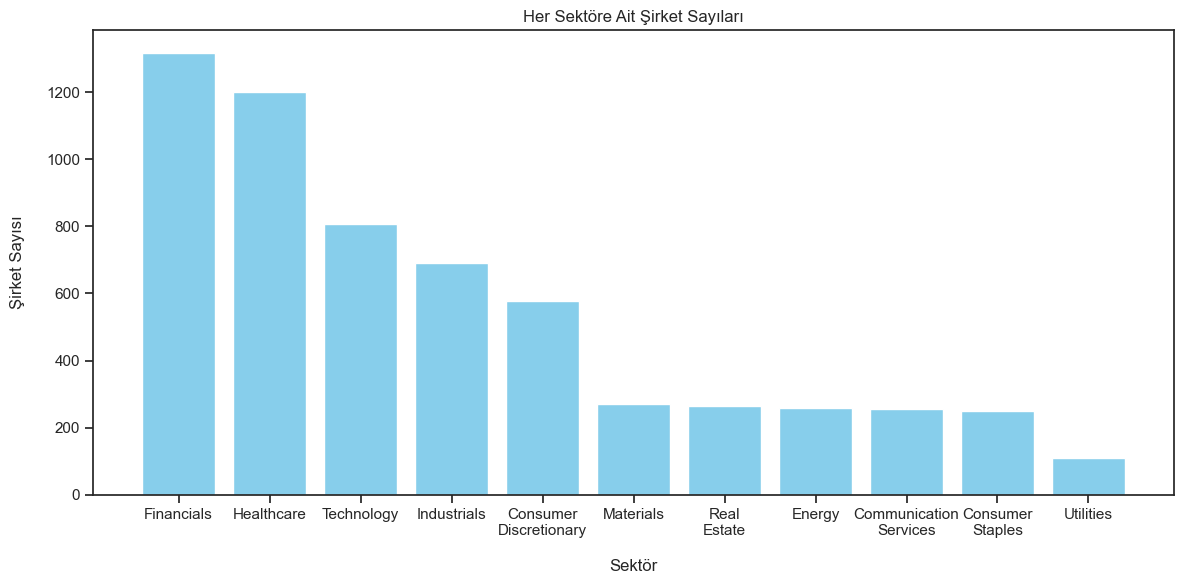

In [329]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks")
sns.set_context("notebook")
plt.figure(figsize=(12, 6))
plt.bar(sectors["Sector Name"].apply(lambda x: x.replace(" ", "\n")), sectors["Stocks"], color='skyblue')
plt.xlabel("Sektör", labelpad=15)
plt.ylabel("Şirket Sayısı", labelpad=15)
plt.title("Her Sektöre Ait Şirket Sayıları")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Örnek bir şirkete ait verileri inceleme

In [330]:
tech_data = fetch_data("technology")
tech_data

,Symbol,Company Name,Market Cap,% Change,Volume,Revenue
0,AAPL,Apple Inc.,"3,688.67B",-0.11%,52954219,395.76B
1,NVDA,NVIDIA Corporation,"3,292.19B",-4.05%,225991924,113.27B
2,MSFT,Microsoft Corporation,"3,034.63B",-1.90%,26086127,261.80B
3,AVGO,Broadcom Inc.,"1,024.94B",-3.56%,24341274,51.57B
4,TSM,Taiwan Semiconductor Manufacturing Company Lim...,865.95B,-0.93%,13720439,88.29B
...,...,...,...,...,...,...
767,SYTA,Siyata Mobile Inc.,1.75M,-1.52%,686104,11.99M
768,SGN,"Signing Day Sports, Inc.",1.69M,1.87%,77277,576.49K
769,CYN,Cyngn Inc.,1.11M,-,1696492,102.12K
770,SOBR,"SOBR Safe, Inc.",1.03M,9.80%,5291379,183.86K


In [331]:
tech_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772 entries, 0 to 771
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Symbol        771 non-null    object
 1   Company Name  772 non-null    object
 2   Market Cap    772 non-null    object
 3   % Change      772 non-null    object
 4   Volume        772 non-null    int64 
 5   Revenue       772 non-null    object
dtypes: int64(1), object(5)
memory usage: 36.3+ KB


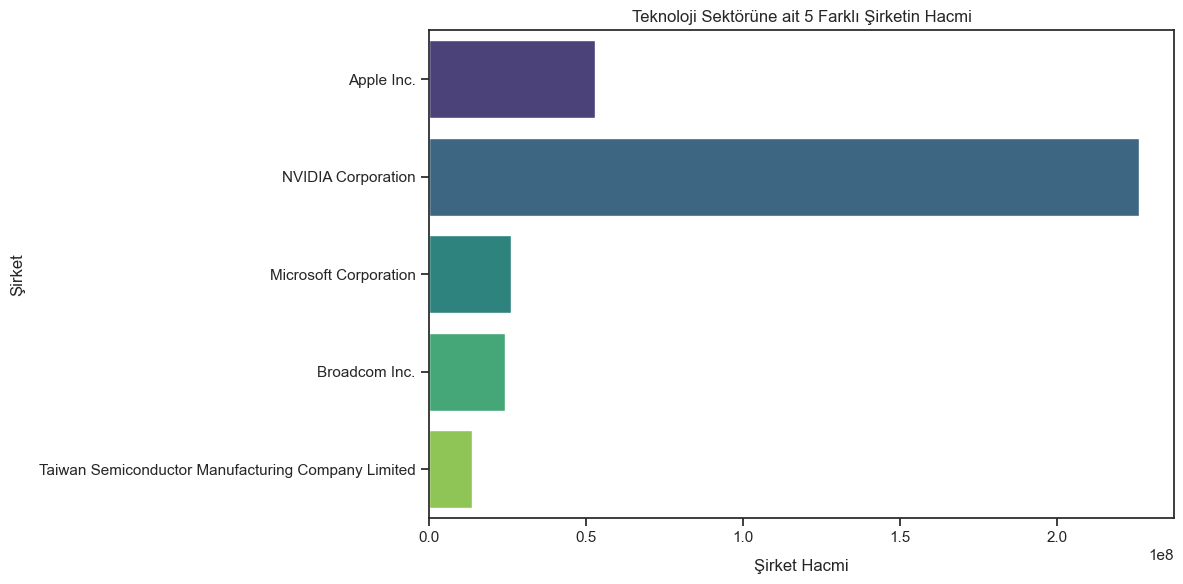

In [332]:
plt.figure(figsize=(12, 6))
sns.set_style("ticks")
sns.set_context("notebook")
sns.barplot(x="Volume", y="Company Name", data=tech_data.head(), palette="viridis")
plt.xlabel("Şirket Hacmi", labelpad=10)
plt.ylabel("Şirket", labelpad=10)
plt.title("Teknoloji Sektörüne ait 5 Farklı Şirketin Hacmi")
plt.tight_layout()
plt.show()

Bütün sektörlere ait verileri kaydetme

In [ ]:
import os
path = "stock_sectors"
os.makedirs(path,exist_ok=True)
for sector_name in sectors["Sector Name"]:
    sector_name = sector_name.lower().replace(" ","-")
    fetch_data(sectors=sector_name).to_csv(os.path.join(path,f"{sector_name}.csv"))

In [18]:
os.listdir(path)

['communication-services.csv',
 'consumer-discretionary.csv',
 'consumer-staples.csv',
 'energy.csv',
 'financials.csv',
 'healthcare.csv',
 'industrials.csv',
 'materials.csv',
 'real-estate.csv',
 'technology.csv',
 'utilities.csv']

Eksik Veri Kontrolü

In [ ]:
for sector_df in os.listdir(path):
    df = pd.read_csv(os.path.join(path,sector_df))
    if df.isnull().sum().sum() != 0:
        nan_values = df.isnull().sum()
        for nan_vlaue in nan_values[nan_values != 0].reset_index().values:
            print(f"\n-------------------{sector_df.split('.')[0]}------------------------\n")
            print(f"{nan_vlaue[0]} sütununda {nan_vlaue[1]} adet değer boş gözükmektedir.")
            nan_companys = df[df[nan_vlaue[0]].isna()][['Company Name']]
            for row in nan_companys.reset_index().values:
                print(f"Bu değer {row[0]} indeksinde {row[1]} şirketine aittir.")

        


-------------------technology------------------------

Symbol sütununda 1 adet değer boş gözükmektedir.
Bu değer 572 indeksinde Nano Labs Ltd şirketine aittir.


Eksik olan bu değerin, verilerin bulunduğu siteden kontrol edildiğinde 'NA' olduğu tespit edilmiştir. Bunun sebebi araştırıldığında ise **fetch_data** ile sektörlere ait verileri çekme sırasında ve **pandas** ile bu veriyi hem kayıt hem de okuma aşamasında "boş değer" olarak algılandığı anlaşılmıştır. Bu yüzden bu veriyi doldurmadan önce değerin tekrardan boş algılanmaması için kayıt sırasında **to_csv** fonksiyonuna **na_rep='NaN'** ve okuma sırasında **pd.read_csv()** fonksiyonuna ise **keep_default_na=False** parametre güncellemesi yapılmıştır.

Not: Aslında bu değere sahip satır, veri setinden silinebilirdi ancak gerçek senaryoda böyle bir veriye ihtiyacımız olabilme durumu göz önüne alındığı için problem, çözme yoluna gidilmiştir.

Eksik Veriyi Düzenleme

In [ ]:
tech_data = pd.read_csv(os.path.join(path,"technology.csv"))
tech_data.isnull().sum()

Unnamed: 0      0
Symbol          1
Company Name    0
Market Cap      0
% Change        0
Volume          0
Revenue         0
dtype: int64

In [ ]:
tech_data.at[572, "Symbol"] = "NA"
tech_data.isnull().sum()

Unnamed: 0      0
Symbol          0
Company Name    0
Market Cap      0
% Change        0
Volume          0
Revenue         0
dtype: int64

In [ ]:
tech_data.to_csv(os.path.join(path,'technology.csv'), index=False, na_rep='NaN') # düzeltilen veriyi kaydetme

In [ ]:
tech_data = pd.read_csv(os.path.join(path,'technology.csv'), keep_default_na=False)
tech_data.isnull().sum() # düzeltilen veriyi kontrol etme

Unnamed: 0      0
Symbol          0
Company Name    0
Market Cap      0
% Change        0
Volume          0
Revenue         0
dtype: int64

## 2.2. Zaman Serisi Veri Setini Hazırlama

Bir önceki bölümde her sektöre ait şirket bilgilerini içeren veriler elde edildi. Bu bölümde ise, elde edilen veriler üzerinden her bir şirkete ait zaman serisi verileri elde edilmiş olup bütün veriler tek bir dataframe üzerinde birleştirilmiştir. Bu işlem için öncelikle en fazla şirkete sahip olan üç sektör belirlenmiş ardından her bir sektörden eşit sayıda (750 adet) şirket adı seçilmiştir. Daha sonra bu bilgiler üzerinden her bir şirketin verileri **yfinance** kullanılarak elde edilmiştir.

En büyük 3 sektörü belirleme

In [ ]:
sectors = sectors.sort_values(by="Stocks",ascending=False)
top_sectors = sectors.iloc[:3]  
print("En büyük 3 sektör:")
top_sectors

En büyük 3 sektör:


,Sector Name,Stocks,Market Cap,Div. Yield,PE Ratio,Profit Margin,1D Change,1Y Change
0,Financials,1318,11.86T,0.17%,15.55,20.19%,-1.42%,30.31%
1,Healthcare,1199,"8,062.50B",0.51%,65.70,2.89%,-0.09%,9.26%
2,Technology,807,21.85T,0.51%,47.14,14.37%,-2.51%,45.77%


Belirlenen sektörler için eşit sayıda şirket seçme

In [ ]:
sector_companies = {}
for sector in top_sectors["Sector Name"]:
    sector_name = sector.lower().replace(" ", "-")
    stocks_count = 750
    df = pd.read_csv(f'./stock_sectors/{sector_name}.csv', keep_default_na=False)
    selected_companies = df["Symbol"].head(stocks_count).tolist() 
    sector_companies[sector] = selected_companies

print("En büyük üç sektöre ait seçilen şirket sayıları:\n")
for sec, comp in sector_companies.items():
    print(f"{sec}: {len(comp)} şirket seçildi.")

En büyük üç sektöre ait seçilen şirket sayıları:

Financials: 750 şirket seçildi.
Healthcare: 750 şirket seçildi.
Technology: 750 şirket seçildi.


Seçilen şirketleri indirme ve düzenleyerek kaydetme

In [138]:
import yfinance as yf

"""Bu fonksiyon tek bir Symbol etiktetine karşılık verilen zaman aralığından 1 aylık aralıklara
zaman serisi verileri çekmektedir. Ancak istenilen zaman aralğında veri yok ise yfinance, veri için mevcut
zaman aralığındaki verileri çekmektedir."""
# Şirket sembolüne ait aylık veri çekme
def fetch_yfinance_data(stock,sector):
    df = yf.download([stock],start='2005-01-01', end='2025-01-31',interval='1mo').reset_index()
    df.columns = df.columns.droplevel(1)  
    up = lambda x: x[0].upper()+x[1:]
    df["Symbol"]=stock
    df["Sector"]=up(sector) # Çekilen veriye hangi sektöre ait olduğunda dair label ekleme
    return df

In [299]:
import time

all_data = pd.DataFrame()  # Tüm sektörlerden gelen verileri saklamak için boş DataFrame
count=0
for sector_name, stocks in sector_companies.items():
    for stock in stocks:  
        count+=1
        if count%100==0: # her 100 şirkette 10 saniye bekleme
            time.sleep(10) # yfinance için 
        pre_data = fetch_yfinance_data(str(stock), sector_name)
        all_data = pd.concat([all_data, pre_data], ignore_index=True)  

# Sonuç: all_data DataFrame'i, tüm sektörlerin verisini alt alta içerir.
all_data.to_csv("all_data.csv", na_rep='NaN')

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[**************

In [300]:
all_data

Price,Date,Adj Close,Close,High,Low,Open,Volume,Symbol,Sector
0,2005-01-01,NaN,21.668674,23.038565,21.192693,22.916668,231082900.0,JPM,Financials
1,2005-02-01,NaN,21.401770,22.291802,21.021165,21.958040,203306200.0,JPM,Financials
2,2005-03-01,NaN,20.259949,22.127847,20.095996,21.665264,266804300.0,JPM,Financials
3,2005-04-01,NaN,20.781080,21.009443,19.528007,20.371197,274126100.0,JPM,Financials
4,2005-05-01,NaN,21.143225,21.468505,20.173298,21.042685,199696300.0,JPM,Financials
...,...,...,...,...,...,...,...,...,...
315040,2024-09-01,NaN,1.230000,1.520000,1.101000,1.450000,65700.0,IMTE,Technology
315041,2024-10-01,NaN,1.729000,2.450000,1.060000,1.230000,1644700.0,IMTE,Technology
315042,2024-11-01,NaN,1.210000,1.900000,1.130000,1.590000,412200.0,IMTE,Technology
315043,2024-12-01,NaN,1.250000,1.600000,1.182000,1.210000,550400.0,IMTE,Technology


In [301]:
all_data.isnull().sum()

Price
Date              0
Adj Close    315045
Close             0
High              0
Low               0
Open              0
Volume            0
Symbol            0
Sector            0
dtype: int64

Elde edilen veriler içinden 3 farklı sektöre ait şirketlerin zaman serisi grafiklerini inceleme

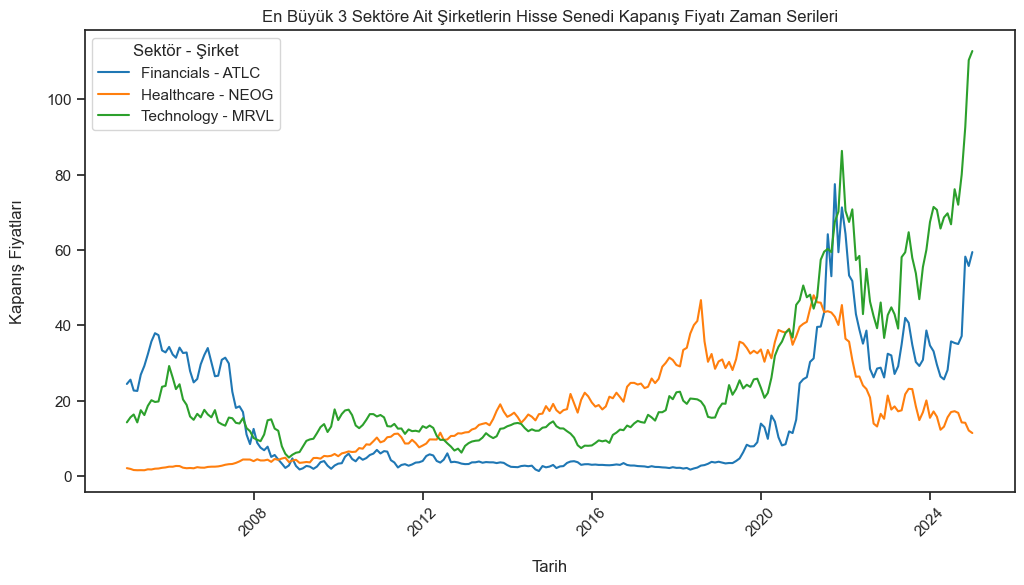

In [302]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sector_names = all_data["Sector"].unique()

plt.figure(figsize=(12, 6)) 
sns.set_style("ticks")  
sns.set_context("notebook") 
palette = sns.color_palette("tab10", len(sector_names))
for i, sect in enumerate(sector_names):
    # İlgili sektöre ait veriyi filtrele
    sec_df = all_data[all_data["Sector"] == sect]
    
    # Sektördeki en fazla veriye sahip olan şirketleri bul
    group_count = sec_df.groupby("Symbol")["Close"].count()
    max_value = group_count.max()
    group_df = group_count[group_count == max_value].reset_index()
    symbol = group_df.iloc[np.random.randint(0,len(group_df)-1), 0]
    
    # Seçilen şirkete ait veriler
    stk_df = sec_df[sec_df["Symbol"] == symbol]
    
    sns.lineplot(data=stk_df, x='Date', y='Close', label=f"{sect} - {symbol}", color=palette[i])  

plt.xlabel('Tarih', labelpad=15)
plt.ylabel('Kapanış Fiyatları', labelpad=15)
plt.title('En Büyük 3 Sektöre Ait Şirketlerin Hisse Senedi Kapanış Fiyatı Zaman Serileri')
plt.legend(title="Sektör - Şirket")  
plt.xticks(rotation=45)  
plt.show()

# 3. Veri Yükleme ve Düzenleme

## 3.1. Manuel İşlem

Bu bölümde veri setine bazı düzenlemeler yapılmıştır. Buna göre kullanılmayacak sütunlar ve 11 aydan daha az veriye sahip şirket verileri veri setinden çıkarılmıştır. Bunun sebebi ise veriyi ilerleyen bölümlerde yapılacak işlemler için uygun hale getirmektir.

In [ ]:
import pandas as pd
from sklearn import set_config
set_config(transform_output="pandas")
import warnings
warnings.filterwarnings("ignore")

train_data = pd.read_csv("all_data.csv", keep_default_na=False)

In [ ]:
train_data

,Unnamed: 0,Date,Adj Close,Close,High,Low,Open,Volume,Symbol,Sector
0,0,2005-01-01,NaN,21.668674,23.038565,21.192693,22.916668,231082900.0,JPM,Financials
1,1,2005-02-01,NaN,21.401770,22.291802,21.021165,21.958040,203306200.0,JPM,Financials
2,2,2005-03-01,NaN,20.259949,22.127847,20.095996,21.665264,266804300.0,JPM,Financials
3,3,2005-04-01,NaN,20.781080,21.009443,19.528007,20.371197,274126100.0,JPM,Financials
4,4,2005-05-01,NaN,21.143225,21.468505,20.173298,21.042685,199696300.0,JPM,Financials
...,...,...,...,...,...,...,...,...,...,...
315040,315040,2024-09-01,NaN,1.230000,1.520000,1.101000,1.450000,65700.0,IMTE,Technology
315041,315041,2024-10-01,NaN,1.729000,2.450000,1.060000,1.230000,1644700.0,IMTE,Technology
315042,315042,2024-11-01,NaN,1.210000,1.900000,1.130000,1.590000,412200.0,IMTE,Technology
315043,315043,2024-12-01,NaN,1.250000,1.600000,1.182000,1.210000,550400.0,IMTE,Technology


**Eksik veri kontrolü**

In [ ]:
train_data.isnull().sum()

Unnamed: 0    0
Date          0
Adj Close     0
Close         0
High          0
Low           0
Open          0
Volume        0
Symbol        0
Sector        0
dtype: int64

**Veriyi düzenleme**

Gereksiz sütunları ve 11 aydan daha az bilgiye sahip şirket verilerini kaldırma

In [ ]:
df = train_data.copy()
# Gereksiz sütunları kaldır
df = df[["Date","Close","Symbol","Sector"]]
# Date sütununu datetime formatına çevir
df = df.assign(Date=pd.to_datetime(df["Date"]))
# 11 aydan az veriye sahip şirketleri çıkarma
preprocess_data =  df[df.groupby("Symbol")["Symbol"].transform("size") >= 11].reset_index(drop=True)
preprocess_data

,Date,Close,Symbol,Sector
0,2005-01-01,21.668674,JPM,Financials
1,2005-02-01,21.401770,JPM,Financials
2,2005-03-01,20.259949,JPM,Financials
3,2005-04-01,20.781080,JPM,Financials
4,2005-05-01,21.143225,JPM,Financials
...,...,...,...,...
314510,2024-09-01,1.230000,IMTE,Technology
314511,2024-10-01,1.729000,IMTE,Technology
314512,2024-11-01,1.210000,IMTE,Technology
314513,2024-12-01,1.250000,IMTE,Technology


In [668]:
preprocess_data.describe()

,Date,Close
count,314515,3.145150e+05
mean,2016-10-09 17:55:07.366580224,9.371173e+03
min,2005-01-01 00:00:00,1.000000e-02
25%,2012-02-01 00:00:00,7.831651e+00
50%,2017-09-01 00:00:00,1.749174e+01
75%,2021-11-01 00:00:00,3.876373e+01
max,2025-01-01 00:00:00,1.974375e+08
std,NaN,1.010674e+06


In [669]:
preprocess_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314515 entries, 0 to 314514
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Date    314515 non-null  datetime64[ns]
 1   Close   314515 non-null  float64       
 2   Symbol  314515 non-null  object        
 3   Sector  314515 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 9.6+ MB


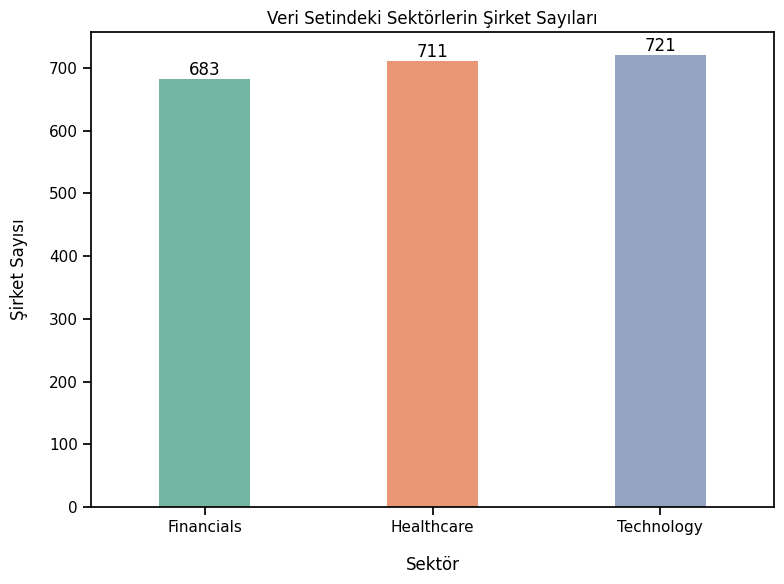

In [670]:
import matplotlib.pyplot as plt
import seaborn as sns

# Şirket sayılarını hesapla
stocks_count = preprocess_data.groupby("Sector")["Symbol"].nunique().reset_index()
stocks_count.columns = ["Sector", "Company Count"]

# Görselleştirme
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=stocks_count, x="Sector", y="Company Count", palette="Set2", width=0.4)

for i in range(len(stocks_count)):
    ax.text(i, stocks_count["Company Count"][i],  
            f'{stocks_count["Company Count"][i]}', ha='center', va='bottom')

plt.xlabel("Sektör", labelpad=15)
plt.ylabel("Şirket Sayısı", labelpad=15)
plt.title("Veri Setindeki Sektörlerin Şirket Sayıları")

plt.tight_layout()
plt.show()


## 3.2. Pipeline

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

preprocessing_pipeline = Pipeline([
    ('drop_columns', FunctionTransformer(lambda X: X[["Date","Close","Symbol","Sector"]])), # kullanılmayacak sütunları kaldırma
    ('convert_date', FunctionTransformer(lambda X: X.assign(Date=pd.to_datetime(X["Date"])))), # tarih sütununu datetime formatına çevirme
    ('filter_symbols', FunctionTransformer(lambda X: X[X.groupby("Symbol")["Symbol"].transform("size") >= 11].reset_index(drop=True))), # 11 aydan daha az veriye sahip şirketleri kaldırma
])

# Genel pipeline yapısına eklenecek kısım
preprocessing_general_pipeline = Pipeline([
    ('data_preprocessing', preprocessing_pipeline),
])

train_data = pd.read_csv("all_data.csv", keep_default_na=False)
preprocess_data = preprocessing_general_pipeline.fit_transform(data)
preprocess_data

,Date,Close,Symbol,Sector
0,2005-01-01,21.668674,JPM,Financials
1,2005-02-01,21.401770,JPM,Financials
2,2005-03-01,20.259949,JPM,Financials
3,2005-04-01,20.781080,JPM,Financials
4,2005-05-01,21.143225,JPM,Financials
...,...,...,...,...
314510,2024-09-01,1.230000,IMTE,Technology
314511,2024-10-01,1.729000,IMTE,Technology
314512,2024-11-01,1.210000,IMTE,Technology
314513,2024-12-01,1.250000,IMTE,Technology


# 4. Veriye Dönüşüm Uygulama

## 4.1. Manuel İşlem

**Dönüşüm Testi**

Bu aşamada veri için en uygun dönüşümün hangisi olduğu belirlenmeye çalışılmıştır.

In [ ]:
from sklearn.preprocessing import PowerTransformer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

preprocess_df = preprocess_data.copy() # bir önceki bölümden gelen veri

# Kapanış fiyatları
close_prices = preprocess_df["Close"]

# Dönüşümler
transformations = {
    "Log Transform (log1p)": np.log1p(close_prices),
    "Reciprocal Transform (1/x)": np.reciprocal(close_prices),
    "Square Root Transform (sqrt)": np.sqrt(close_prices),
    "Power Transform (Yeo-Johnson)": PowerTransformer(method='yeo-johnson').fit_transform(close_prices.values.reshape(-1,1)).values.ravel()
}

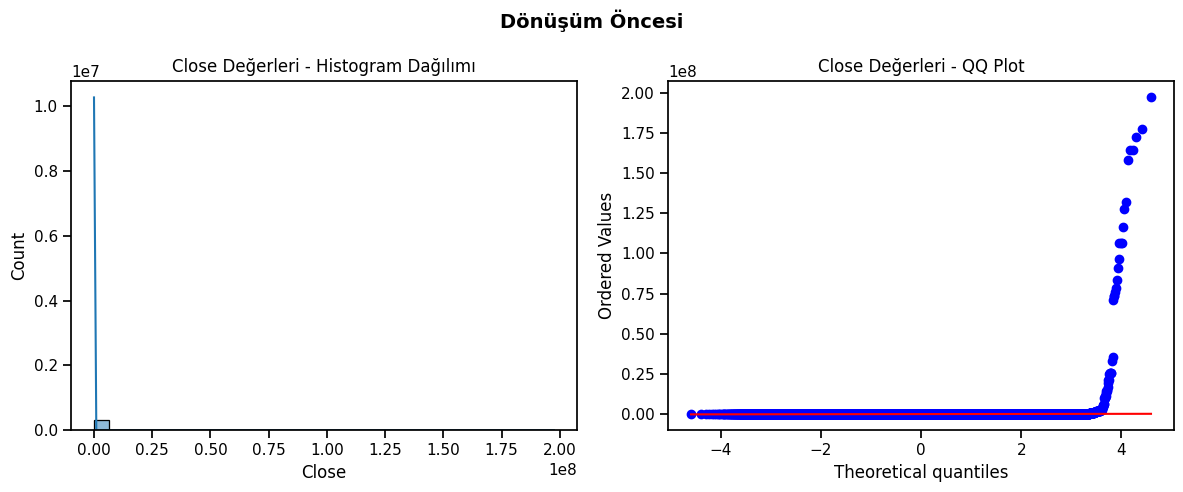

In [673]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Dönüşüm Öncesi", fontsize=14, fontweight="bold")
# Histogram 
sns.histplot(close_prices, kde=True, ax=axes[0], bins=30)
axes[0].set_title("Close Değerleri - Histogram Dağılımı")
# QQ Plot
stats.probplot(np.array(close_prices).ravel(), dist="norm", plot=axes[1]) 
axes[1].set_title("Close Değerleri - QQ Plot")
plt.tight_layout()
plt.show()

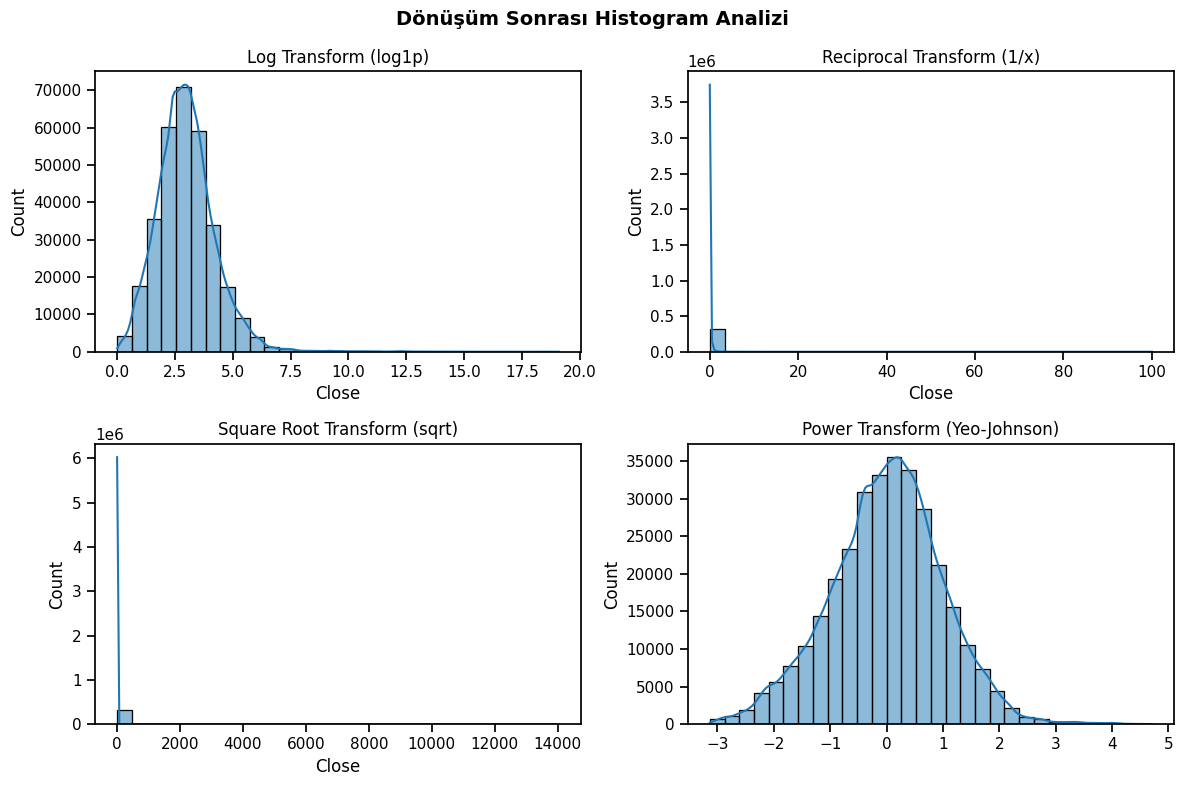

In [695]:
# Histogram 
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Dönüşüm Sonrası Histogram Analizi", fontsize=14, fontweight="bold")
axes = axes.flatten()
for i, (name, data) in enumerate(transformations.items()):
    sns.histplot(data, kde=True, ax=axes[i], bins=30)
    axes[i].set_title(name)
plt.tight_layout()
plt.show()

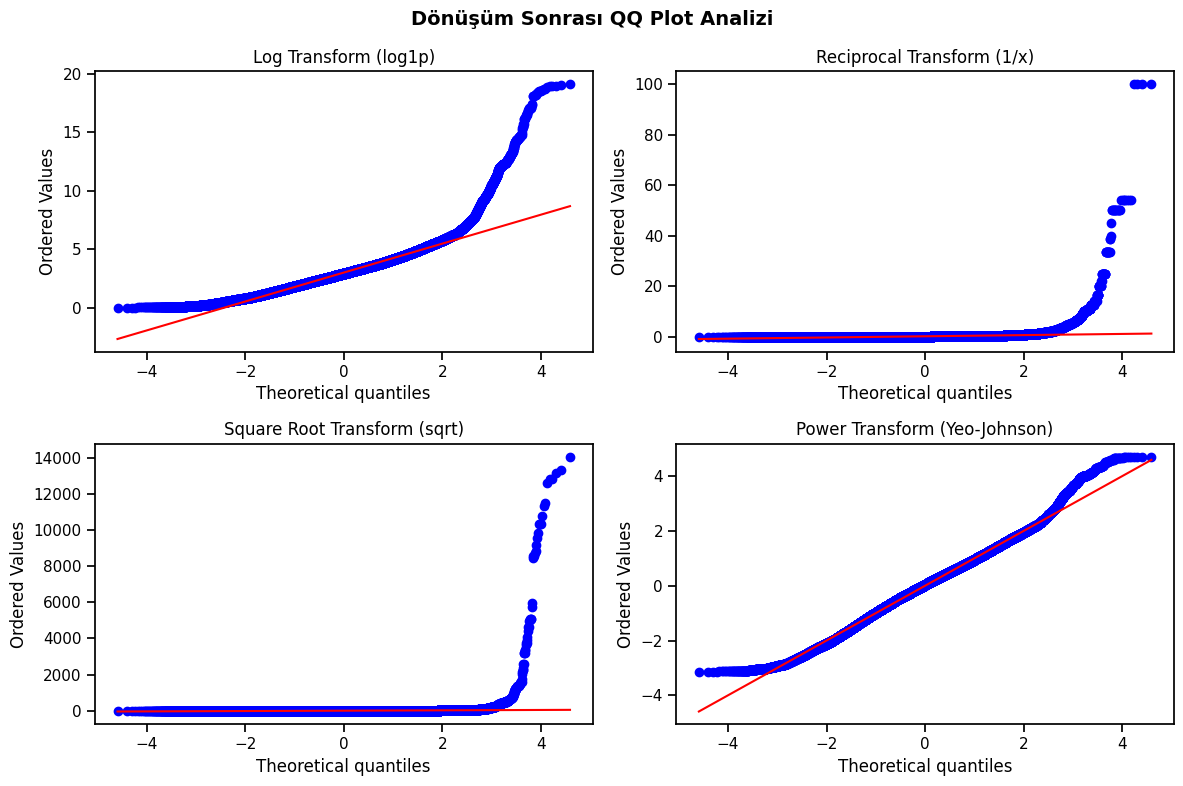

In [675]:
# QQ Plot 
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Dönüşüm Sonrası QQ Plot Analizi", fontsize=14, fontweight="bold")
axes = axes.flatten()
for i, (name, data) in enumerate(transformations.items()):
    stats.probplot(np.array(data).ravel(), dist="norm", plot=axes[i]) 
    axes[i].set_title(name)
plt.tight_layout()  
plt.show()

Dönüşüm öncesi ve dönüşüm sonrası grafikler incelendiğinde veri için en uygun dönüşümün Yeo-Johnson dönüşümü olduğuna karar verilmiştir.

In [676]:
from sklearn.preprocessing import PowerTransformer

preprocess_df = preprocess_data.copy()
transformer = PowerTransformer(method='yeo-johnson')
numeric_cols = preprocess_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
preprocess_df[numeric_cols]=transformer.fit_transform(preprocess_df[numeric_cols])
transformed_data = preprocess_df
transformed_data.head()

,Date,Close,Symbol,Sector
0,2005-01-01,0.205646,JPM,Financials
1,2005-02-01,0.195974,JPM,Financials
2,2005-03-01,0.153023,JPM,Financials
3,2005-04-01,0.172953,JPM,Financials
4,2005-05-01,0.186477,JPM,Financials


## 4.2. Pipeline

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, FunctionTransformer
import numpy as np


transformer_pipeline = Pipeline([
    ('transformer', FunctionTransformer(lambda X: PowerTransformer(method='yeo-johnson').fit_transform(X))), 
])

transformer_preprocessor = ColumnTransformer([
    ('column_transformer', transformer_pipeline, lambda X: X.select_dtypes(include=[np.number]).columns.tolist()), # sadece sayısal değişkenlere uygulama
], remainder='passthrough', verbose_feature_names_out=False)

# Genel pipeline yapısına eklenecek kısım
transformer_general_pipeline = Pipeline([
    ('transformer', transformer_preprocessor),
])

preprocess_df = preprocess_data.copy() # bir önceki bölümden gelen veri
transformed_data = transformer_general_pipeline.fit_transform(preprocess_df)
transformed_data

,Close,Date,Symbol,Sector
0,0.205646,2005-01-01,JPM,Financials
1,0.195974,2005-02-01,JPM,Financials
2,0.153023,2005-03-01,JPM,Financials
3,0.172953,2005-04-01,JPM,Financials
4,0.186477,2005-05-01,JPM,Financials
...,...,...,...,...
314510,-2.110825,2024-09-01,IMTE,Technology
314511,-1.871080,2024-10-01,IMTE,Technology
314512,-2.121713,2024-11-01,IMTE,Technology
314513,-2.100051,2024-12-01,IMTE,Technology


# 5. Veriyi Ölçeklendirme

## 5.1. Manuel İşlem

Bu bölümde veri için uygun olan ölçeklendirme yöntemi belirlenmeye çalışılmıştır.

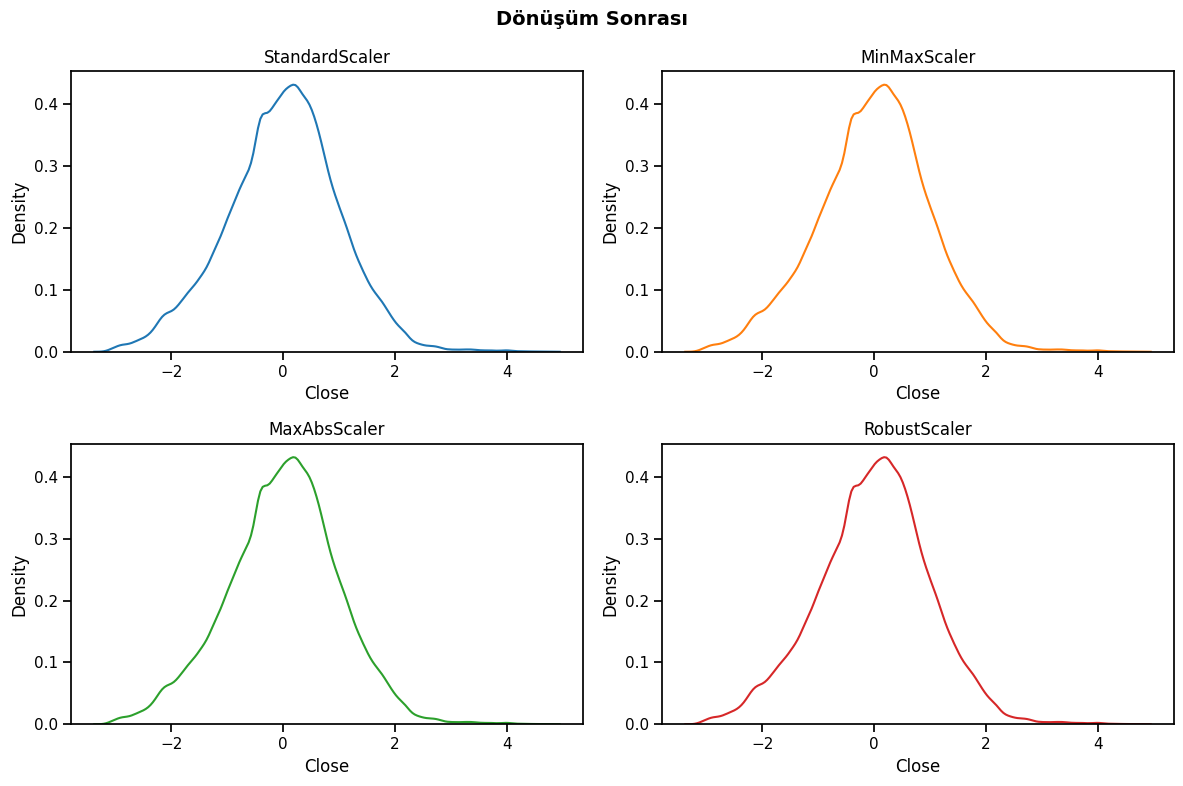

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,RobustScaler
import numpy as np

transformed_df = transformed_data.copy() # bir önceki bölümden gelen veri

# Kapanış fiyatları
close_prices = transformed_df["Close"]

# Ölçeklendirme
scalers = {
    "StandardScaler": StandardScaler().fit_transform(close_prices.values.reshape(-1,1)),
    "MinMaxScaler": MinMaxScaler().fit_transform(close_prices.values.reshape(-1,1)),
    "MaxAbsScaler": MaxAbsScaler().fit_transform(close_prices.values.reshape(-1,1)),
    "RobustScaler": RobustScaler().fit_transform(close_prices.values.reshape(-1,1))
}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Dönüşüm Sonrası", fontsize=14, fontweight="bold")
axes = axes.flatten()
palette = sns.color_palette("tab10", len(scalers))
for i, (name, data) in enumerate(scalers.items()):
    sns.kdeplot(close_prices, ax=axes[i], color=palette[i])
    axes[i].set_title(name)
plt.tight_layout()
plt.show()

Yapılan inceleme sonuncunda tüm ölçeklendirme yöntemlerinde benzer sonuç elde edilmiştir. Ancak finansal verilerde aykırı değerlerin sıkça görülmesi (örneğin, ani fiyat dalgalanmaları veya aşırı yüksek/düşük değerler) ve Robust Scaler yönteminin ise bu değerlere daha dayanıklı olması nedeniyle bu yöntem tercih edilmiştir. Çünkü Robust Scaler medyan ve IQR (Interquartile Range) kullanarak ölçeklendirme yaptığı için aykırı değerlerden çok fazla etkilenmemektedir. Bu nedenler verilerin ölçeklendirilmesi sırasında istenmeyen sapmaların önüne geçmeye ve makine öğrenimi modellerinin daha stabil ve tutarlı sonuçlar üretmesine yardımcı olur.

In [700]:
transform_df = transformed_data.copy()
numeric_cols = transform_df.select_dtypes(include=[np.number]).columns
transform_df[numeric_cols] = RobustScaler().fit_transform(transform_df[numeric_cols])
scaled_data = transform_df
scaled_data

,Close,Date,Symbol,Sector
0,0.132993,2005-01-01,JPM,Financials
1,0.125383,2005-02-01,JPM,Financials
2,0.091589,2005-03-01,JPM,Financials
3,0.107270,2005-04-01,JPM,Financials
4,0.117910,2005-05-01,JPM,Financials
...,...,...,...,...
314510,-1.689593,2024-09-01,IMTE,Technology
314511,-1.500963,2024-10-01,IMTE,Technology
314512,-1.698159,2024-11-01,IMTE,Technology
314513,-1.681115,2024-12-01,IMTE,Technology


## 5.2. Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
import numpy as np

scaler_pipeline = Pipeline([
    ('scaler', RobustScaler()),
])

scaler_preprocessor = ColumnTransformer([
    ('column_scaler', scaler_pipeline, lambda X: X.select_dtypes(include=[np.number]).columns.tolist()),
], remainder='passthrough', verbose_feature_names_out=False)


# Genel pipeline yapısına eklenecek kısım
scaler_general_pipeline = Pipeline([
    ('scaler', scaler_preprocessor),
])

transformed_df = transformed_data.copy() # bir önceki bölümden gelen veri
scaled_data = scaler_general_pipeline.fit_transform(transformed_df)
scaled_data

,Close,Date,Symbol,Sector
0,0.132993,2005-01-01,JPM,Financials
1,0.125383,2005-02-01,JPM,Financials
2,0.091589,2005-03-01,JPM,Financials
3,0.107270,2005-04-01,JPM,Financials
4,0.117910,2005-05-01,JPM,Financials
...,...,...,...,...
314510,-1.689593,2024-09-01,IMTE,Technology
314511,-1.500963,2024-10-01,IMTE,Technology
314512,-1.698159,2024-11-01,IMTE,Technology
314513,-1.681115,2024-12-01,IMTE,Technology


# 6. Veriyi Encode Etme

## 6.1. Manuel İşlem

Bu bölümde kategorik değişkenlere CatBoost Encode uygulanırken hedef değişkene ise Label Encode işlemi uygulanmıştır. Ancak CatBoost Encode işlemi sırasında bir problem farkedilmiş olup bu sorun farklı bir yöntem ile çözülmeye çalışılmıştır.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from category_encoders import CatBoostEncoder

scaled_df = scaled_data.copy() # bir önceki bölümden gelen veri

# Veri ayrımı
X = scaled_df.drop(columns=['Sector'])
y = scaled_df['Sector']

# Hedef değişkene Label Encoding uygulama
y_enc = LabelEncoder().fit_transform(y)

# CatBoost Encoding
cbe_encoder = CatBoostEncoder(cols=["Symbol"])
cbe_encoder.fit(X, y_enc)
X_enc = cbe_encoder.transform(X)

In [703]:
# Encode edilmiş veri ile ayrılmış verileri birleştirme
encoded_data = X_enc.assign(
    Symbol_original=scaled_df["Symbol"],
    Sector=y_enc,
    Sector_original=y,
)

In [704]:
encoded_data

,Close,Date,Symbol,Symbol_original,Sector,Sector_original
0,0.132993,2005-01-01,0.003868,JPM,0,Financials
1,0.125383,2005-02-01,0.003868,JPM,0,Financials
2,0.091589,2005-03-01,0.003868,JPM,0,Financials
3,0.107270,2005-04-01,0.003868,JPM,0,Financials
4,0.117910,2005-05-01,0.003868,JPM,0,Financials
...,...,...,...,...,...,...
314510,-1.689593,2024-09-01,1.988309,IMTE,2,Technology
314511,-1.500963,2024-10-01,1.988309,IMTE,2,Technology
314512,-1.698159,2024-11-01,1.988309,IMTE,2,Technology
314513,-1.681115,2024-12-01,1.988309,IMTE,2,Technology


In [705]:
print(f"Toplam şirket sayısı: {encoded_data['Symbol_original'].nunique()}")
print(f"Encode işleminden sonraki toplam şirket sayısı: {encoded_data['Symbol'].nunique()}")

Toplam şirket sayısı: 2115
Encode işleminden sonraki toplam şirket sayısı: 485


Encode edilmiş veri incelendiğinde, farklı Symbol değerlerinde bir azalma olduğu gözlemlenmiştir. Bu durum, istenmeyen bir sonuçtur çünkü veri setindeki zaman serisi verileri, her bir Symbol değerine (yani her bir şirkete) özeldir. Ancak, encode işlemi sonrasında bazı Symbol değerleri aynı encode değerini aldığı için, bu değerler tek bir şirket gibi temsil edilmektedir. Bu durum, bilgi kaybına ve modelin yanlış öğrenmesine neden olabilmektedir.

Bu problemi çözmek için bir yöntem önerilmiştir. Bu yöntem, CatBoost Encoding algoritmasının temel mantığından esinlenerek geliştirilmiştir. CatBoost Encoding, encode edilecek veri ile hedef değişken arasındaki ilişkiyi kurarak, kategorik değişkenleri sayısal değerlere dönüştürür. Bu mantıktan yola çıkarak, encode sonrası Symbol değerleri ile veri setindeki başka bir değer arasında ilişki kurulması hedeflenmiştir.

Önerilen yöntemde, her bir şirketin (Symbol değerinin) Close değerlerinin ortalaması hesaplanmış ve bu ortalama değerler, CatBoost Encoding ile elde edilen Symbol encode değerlerine eklenmiştir. Bu yaklaşımın temel amacı, her bir şirketin benzersiz bir şekilde temsil edilmesini sağlamaktır. Buradaki kritik nokta, her bir şirketin Close değerlerinin ortalamasının benzersiz olmasıdır. Gerçek dünya problemlerinde, farklı şirketlerin tüm zamanlarındaki ortalama Close değerlerinin aynı olması çok düşük bir ihtimaldir. Bu nedenle, bu ortalama değerlerin her bir şirket için benzersiz olması, encode edilmiş Symbol değerlerinin de benzersiz olmasını sağlamaktadır.

Bu yöntem sayesinde, encode edilmiş veriler hem benzersiz hem de veri seti ile hedef değişken arasında ilişkili hale getirilmiştir. Bu, modelin daha doğru ve tutarlı sonuçlar üretmesine yardımcı olacaktır.

In [706]:
# Ortalama Close hesaplama
close_mean = scaled_df.groupby("Symbol")["Close"].transform("mean")
close_mean

0         0.630151
1         0.630151
2         0.630151
3         0.630151
4         0.630151
            ...   
314510    0.079192
314511    0.079192
314512    0.079192
314513    0.079192
314514    0.079192
Name: Close, Length: 314515, dtype: float64

In [707]:
close_mean.nunique()

2115

In [708]:
encoded_data = encoded_data.assign(
    Symbol=encoded_data["Symbol"] + close_mean # encode edilmiş Symbol değerine ortalama Close değerlerini ekleme
)

encoded_data = encoded_data[["Date", "Close", "Symbol", "Symbol_original", "Sector","Sector_original"]].sort_values(by=["Symbol", "Date"]).reset_index(drop=True)

encoded_data

,Date,Close,Symbol,Symbol_original,Sector,Sector_original
0,2011-02-01,-1.510782,-1.584422,HIVE,0,Financials
1,2011-03-01,-1.620219,-1.584422,HIVE,0,Financials
2,2011-04-01,-1.620219,-1.584422,HIVE,0,Financials
3,2011-05-01,-1.724413,-1.584422,HIVE,0,Financials
4,2011-06-01,-1.724413,-1.584422,HIVE,0,Financials
...,...,...,...,...,...,...
314510,2024-09-01,-0.894123,4.431551,UAVS,2,Technology
314511,2024-10-01,-1.238013,4.431551,UAVS,2,Technology
314512,2024-11-01,-0.452890,4.431551,UAVS,2,Technology
314513,2024-12-01,-1.066246,4.431551,UAVS,2,Technology


In [709]:
print(f"Toplam şirket sayısı: {encoded_data['Symbol_original'].nunique()}")
print(f"Encode işleminden sonraki toplam şirket sayısı: {encoded_data['Symbol'].nunique()}")

Toplam şirket sayısı: 2115
Encode işleminden sonraki toplam şirket sayısı: 2115


## 6.2. Pipeline

In [ ]:
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from category_encoders import CatBoostEncoder
from sklearn.pipeline import Pipeline

encoder_pipeline = Pipeline([
    ('data_split', FunctionTransformer(lambda X: (
        X.drop(['Sector'], axis=1), # encode edilecek veri
        X['Sector'], # hedef değişken
        X # verinin kopyası   
    ))),

    ('label_encode', FunctionTransformer(lambda X: (
        X[0], # encode edilecek veri
        LabelEncoder().fit_transform(X[1]), # label encode edilmiş hedef değişken
        X[2] # verinin kopyası   
    ))),

    ('catboost_encode', FunctionTransformer(lambda X: (
        CatBoostEncoder(cols=["Symbol"])
        .fit(X[0], X[1])
        .transform(X[0]), # encode edilmiş veri
        X[1], # hedef değişken
        X[2] # verinin kopyası   
    ))),

    ('close_mean', FunctionTransformer(lambda X: (
        X[2].groupby("Symbol")["Close"].transform("mean"), # verinin kopyasından hesaplanan her bir şirkete ait ortalama Close değerleri
        X[0], # encode edilmiş veri 
        X[1], # hedef değişken
        X[2] # verinin kopyası
    ))),

    ('data_merge', FunctionTransformer(lambda X: 
        X[1].assign(
            Sector=X[2], 
            Symbol_original=X[3]["Symbol"], 
            Symbol=X[1]["Symbol"] + X[0], # encode edilmiş veri, hedef değişken ve ortalama Close değerlerini encode edilmiş veride bir araya getirme
            Sector_original = X[3]["Sector"]),
    )),

    ('column_design', FunctionTransformer(lambda X: 
        X[["Date", "Close", "Symbol", "Symbol_original", "Sector","Sector_original"]]
        .sort_values(by=["Symbol", "Date"])
        .reset_index(drop=True) # sütun sıralarını ve satır indekslerini düzenleme
    )),
])


# Genel pipeline yapısına eklenecek kısım
encoder_general_pipeline = Pipeline([
    ('encoder', encoder_pipeline), 
])

scale_df = scaled_data.copy() # bir önceki bölümden gelen veri
encoded_data = encoder_general_pipeline.fit_transform(scale_df)
encoded_data

,Date,Close,Symbol,Symbol_original,Sector,Sector_original
0,2011-02-01,-1.510782,-1.584422,HIVE,0,Financials
1,2011-03-01,-1.620219,-1.584422,HIVE,0,Financials
2,2011-04-01,-1.620219,-1.584422,HIVE,0,Financials
3,2011-05-01,-1.724413,-1.584422,HIVE,0,Financials
4,2011-06-01,-1.724413,-1.584422,HIVE,0,Financials
...,...,...,...,...,...,...
314510,2024-09-01,-0.894123,4.431551,UAVS,2,Technology
314511,2024-10-01,-1.238013,4.431551,UAVS,2,Technology
314512,2024-11-01,-0.452890,4.431551,UAVS,2,Technology
314513,2024-12-01,-1.066246,4.431551,UAVS,2,Technology


# 7. Veriden Özellik Çıkarma

## 7.1. Manuel İşlem

Bu bölümde encode edilmiş veri setimizden tsfresh kütüphanesi kullanarak otomatik öznitelikler çıkarılması hedeflenmiştir. Ele aldığımız problem bir finans problemi olduğundan dolayı, zaman serisi verilerinin karmaşık yapısını daha iyi modelleyebilmek ve anlamlı özellikler elde etmek için bu yöntem tercih edilmiştir. tsfresh, zaman serisi verilerinden otomatik olarak yüzlerce istatistiksel ve matematiksel özellik çıkarabilen güçlü bir kütüphanedir. Bu yüzden çıkarılan bu özellikler, veri setindeki gizli desenleri ve ilişkileri ortaya çıkarmak için kullanılabilmektedir.

In [ ]:
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters
from tsfresh import extract_features

encoded_df = encoded_data.copy() # bir önceki bölümden gelen veri
extracted_features = extract_features(encoded_df, 
                                      column_id="Symbol", 
                                      column_sort="Date",
                                      column_value="Close",
                                      default_fc_parameters=EfficientFCParameters(),
                                      )

extracted_features

Feature Extraction: 100%|██████████| 40/40 [01:45<00:00,  2.65s/it]


,Close__variance_larger_than_standard_deviation,Close__has_duplicate_max,Close__has_duplicate_min,Close__has_duplicate,Close__sum_values,Close__abs_energy,Close__mean_abs_change,Close__mean_change,Close__mean_second_derivative_central,Close__median,...,Close__fourier_entropy__bins_5,Close__fourier_entropy__bins_10,Close__fourier_entropy__bins_100,Close__permutation_entropy__dimension_3__tau_1,Close__permutation_entropy__dimension_4__tau_1,Close__permutation_entropy__dimension_5__tau_1,Close__permutation_entropy__dimension_6__tau_1,Close__permutation_entropy__dimension_7__tau_1,Close__query_similarity_count__query_None__threshold_0.0,Close__mean_n_absolute_max__number_of_maxima_7
-1.584422,0.0,0.0,1.0,1.0,-267.113520,518.066569,0.103186,0.002004,0.000383,-1.724413,...,0.238690,0.302082,0.978607,1.621124,2.713357,3.619621,4.231608,4.544231,NaN,2.402853
-1.529793,0.0,0.0,0.0,1.0,-101.888473,171.440060,0.126585,0.002517,0.001497,-1.595200,...,0.395372,0.525304,1.062604,1.669180,2.700753,3.417108,3.792708,3.955715,NaN,2.214819
-1.513214,0.0,0.0,0.0,1.0,-365.616934,569.422132,0.034148,0.002184,0.000118,-1.485051,...,0.095661,0.179587,0.581905,1.721892,2.946807,4.129425,4.853035,5.141245,NaN,2.146092
-1.493049,0.0,0.0,0.0,1.0,-68.102982,107.201492,0.081455,-0.027458,0.001983,-1.636773,...,0.642858,0.642858,1.638797,1.496745,2.407432,3.002610,3.159847,3.278750,NaN,1.772985
-1.261602,0.0,0.0,0.0,1.0,-304.978444,427.318001,0.072340,0.000296,-0.000114,-1.385169,...,0.168130,0.227173,0.380957,1.776521,3.080422,4.330990,5.144004,5.380670,NaN,1.776969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3.677190,0.0,0.0,0.0,0.0,91.612786,195.208664,0.103232,-0.053623,-0.000688,2.080248,...,0.306829,0.458208,0.854018,1.545391,2.444642,2.979006,3.308738,3.495746,NaN,2.274741
3.890813,0.0,0.0,0.0,1.0,456.745486,906.655554,0.075433,-0.013079,-0.001406,2.019613,...,0.143387,0.191044,0.550193,1.751942,3.013465,4.269433,4.972583,5.279605,NaN,2.413388
3.936097,1.0,0.0,0.0,1.0,175.300955,476.692617,0.097096,-0.051646,-0.001564,2.401307,...,0.312737,0.312737,0.518718,1.436018,2.305248,3.042596,3.511221,3.819710,NaN,3.122316
4.251434,0.0,0.0,0.0,1.0,277.981650,735.532985,0.080527,-0.031343,-0.000432,2.587663,...,0.164865,0.246897,0.438174,1.657965,2.753630,3.750939,4.273127,4.523633,NaN,3.132497


In [712]:
extracted_features = extracted_features.reset_index(names="Symbol") # çıkarılan özellik verisinde indeks sütununu düzenleme
extracted_features

,Symbol,Close__variance_larger_than_standard_deviation,Close__has_duplicate_max,Close__has_duplicate_min,Close__has_duplicate,Close__sum_values,Close__abs_energy,Close__mean_abs_change,Close__mean_change,Close__mean_second_derivative_central,...,Close__fourier_entropy__bins_5,Close__fourier_entropy__bins_10,Close__fourier_entropy__bins_100,Close__permutation_entropy__dimension_3__tau_1,Close__permutation_entropy__dimension_4__tau_1,Close__permutation_entropy__dimension_5__tau_1,Close__permutation_entropy__dimension_6__tau_1,Close__permutation_entropy__dimension_7__tau_1,Close__query_similarity_count__query_None__threshold_0.0,Close__mean_n_absolute_max__number_of_maxima_7
0,-1.584422,0.0,0.0,1.0,1.0,-267.113520,518.066569,0.103186,0.002004,0.000383,...,0.238690,0.302082,0.978607,1.621124,2.713357,3.619621,4.231608,4.544231,NaN,2.402853
1,-1.529793,0.0,0.0,0.0,1.0,-101.888473,171.440060,0.126585,0.002517,0.001497,...,0.395372,0.525304,1.062604,1.669180,2.700753,3.417108,3.792708,3.955715,NaN,2.214819
2,-1.513214,0.0,0.0,0.0,1.0,-365.616934,569.422132,0.034148,0.002184,0.000118,...,0.095661,0.179587,0.581905,1.721892,2.946807,4.129425,4.853035,5.141245,NaN,2.146092
3,-1.493049,0.0,0.0,0.0,1.0,-68.102982,107.201492,0.081455,-0.027458,0.001983,...,0.642858,0.642858,1.638797,1.496745,2.407432,3.002610,3.159847,3.278750,NaN,1.772985
4,-1.261602,0.0,0.0,0.0,1.0,-304.978444,427.318001,0.072340,0.000296,-0.000114,...,0.168130,0.227173,0.380957,1.776521,3.080422,4.330990,5.144004,5.380670,NaN,1.776969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,3.677190,0.0,0.0,0.0,0.0,91.612786,195.208664,0.103232,-0.053623,-0.000688,...,0.306829,0.458208,0.854018,1.545391,2.444642,2.979006,3.308738,3.495746,NaN,2.274741
2111,3.890813,0.0,0.0,0.0,1.0,456.745486,906.655554,0.075433,-0.013079,-0.001406,...,0.143387,0.191044,0.550193,1.751942,3.013465,4.269433,4.972583,5.279605,NaN,2.413388
2112,3.936097,1.0,0.0,0.0,1.0,175.300955,476.692617,0.097096,-0.051646,-0.001564,...,0.312737,0.312737,0.518718,1.436018,2.305248,3.042596,3.511221,3.819710,NaN,3.122316
2113,4.251434,0.0,0.0,0.0,1.0,277.981650,735.532985,0.080527,-0.031343,-0.000432,...,0.164865,0.246897,0.438174,1.657965,2.753630,3.750939,4.273127,4.523633,NaN,3.132497


**Özellik çıkarma sırasında çıkarılan sütunları geri ekleme**

In [713]:
extracted_features=extracted_features.merge(encoded_data[["Symbol", "Symbol_original", "Sector", "Sector_original"]].drop_duplicates(),on="Symbol",how="left")
extracted_features

,Symbol,Close__variance_larger_than_standard_deviation,Close__has_duplicate_max,Close__has_duplicate_min,Close__has_duplicate,Close__sum_values,Close__abs_energy,Close__mean_abs_change,Close__mean_change,Close__mean_second_derivative_central,...,Close__permutation_entropy__dimension_3__tau_1,Close__permutation_entropy__dimension_4__tau_1,Close__permutation_entropy__dimension_5__tau_1,Close__permutation_entropy__dimension_6__tau_1,Close__permutation_entropy__dimension_7__tau_1,Close__query_similarity_count__query_None__threshold_0.0,Close__mean_n_absolute_max__number_of_maxima_7,Symbol_original,Sector,Sector_original
0,-1.584422,0.0,0.0,1.0,1.0,-267.113520,518.066569,0.103186,0.002004,0.000383,...,1.621124,2.713357,3.619621,4.231608,4.544231,NaN,2.402853,HIVE,0,Financials
1,-1.529793,0.0,0.0,0.0,1.0,-101.888473,171.440060,0.126585,0.002517,0.001497,...,1.669180,2.700753,3.417108,3.792708,3.955715,NaN,2.214819,BITF,0,Financials
2,-1.513214,0.0,0.0,0.0,1.0,-365.616934,569.422132,0.034148,0.002184,0.000118,...,1.721892,2.946807,4.129425,4.853035,5.141245,NaN,2.146092,OXSQ,0,Financials
3,-1.493049,0.0,0.0,0.0,1.0,-68.102982,107.201492,0.081455,-0.027458,0.001983,...,1.496745,2.407432,3.002610,3.159847,3.278750,NaN,1.772985,WDH,0,Financials
4,-1.261602,0.0,0.0,0.0,1.0,-304.978444,427.318001,0.072340,0.000296,-0.000114,...,1.776521,3.080422,4.330990,5.144004,5.380670,NaN,1.776969,SIEB,0,Financials
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,3.677190,0.0,0.0,0.0,0.0,91.612786,195.208664,0.103232,-0.053623,-0.000688,...,1.545391,2.444642,2.979006,3.308738,3.495746,NaN,2.274741,MAXN,2,Technology
2111,3.890813,0.0,0.0,0.0,1.0,456.745486,906.655554,0.075433,-0.013079,-0.001406,...,1.751942,3.013465,4.269433,4.972583,5.279605,NaN,2.413388,RIME,2,Technology
2112,3.936097,1.0,0.0,0.0,1.0,175.300955,476.692617,0.097096,-0.051646,-0.001564,...,1.436018,2.305248,3.042596,3.511221,3.819710,NaN,3.122316,FRGT,2,Technology
2113,4.251434,0.0,0.0,0.0,1.0,277.981650,735.532985,0.080527,-0.031343,-0.000432,...,1.657965,2.753630,3.750939,4.273127,4.523633,NaN,3.132497,VERB,2,Technology


## 7.2. Pipeline

In [ ]:
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, EfficientFCParameters
from tsfresh import extract_features
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline


feature_extract_pipeline = Pipeline([
    ('feature_extract', FunctionTransformer(lambda X: (
        extract_features(X, 
            column_id="Symbol", 
            column_sort="Date", 
            column_value="Close", 
            default_fc_parameters=EfficientFCParameters())
            .reset_index(names="Symbol"), # özellik çıkarılan veri
        X # orijinal veri
    ))),

    ('data_merge', FunctionTransformer(lambda X: (
        X[0]
        .merge(X[1][["Symbol", "Symbol_original", "Sector", "Sector_original"]].drop_duplicates(), 
               on="Symbol", 
               how="left") # Özellik çıkarma sırasında çıkarılan sütunları geri ekleme
    )))
])


# Genel pipeline yapısına eklenecek kısım
feature_extract_general_pipeline = Pipeline([
    ('feature_extractor', feature_extract_pipeline), 
])

encoded_df = encoded_data.copy() # bir önceki bölümden gelen veri
extracted_features = feature_extract_general_pipeline.fit_transform(encoded_df)
extracted_features

Feature Extraction: 100%|██████████| 40/40 [02:12<00:00,  3.30s/it]


,Symbol,Close__variance_larger_than_standard_deviation,Close__has_duplicate_max,Close__has_duplicate_min,Close__has_duplicate,Close__sum_values,Close__abs_energy,Close__mean_abs_change,Close__mean_change,Close__mean_second_derivative_central,...,Close__permutation_entropy__dimension_3__tau_1,Close__permutation_entropy__dimension_4__tau_1,Close__permutation_entropy__dimension_5__tau_1,Close__permutation_entropy__dimension_6__tau_1,Close__permutation_entropy__dimension_7__tau_1,Close__query_similarity_count__query_None__threshold_0.0,Close__mean_n_absolute_max__number_of_maxima_7,Symbol_original,Sector,Sector_original
0,-1.584422,0.0,0.0,1.0,1.0,-267.113520,518.066569,0.103186,0.002004,0.000383,...,1.621124,2.713357,3.619621,4.231608,4.544231,NaN,2.402853,HIVE,0,Financials
1,-1.529793,0.0,0.0,0.0,1.0,-101.888473,171.440060,0.126585,0.002517,0.001497,...,1.669180,2.700753,3.417108,3.792708,3.955715,NaN,2.214819,BITF,0,Financials
2,-1.513214,0.0,0.0,0.0,1.0,-365.616934,569.422132,0.034148,0.002184,0.000118,...,1.721892,2.946807,4.129425,4.853035,5.141245,NaN,2.146092,OXSQ,0,Financials
3,-1.493049,0.0,0.0,0.0,1.0,-68.102982,107.201492,0.081455,-0.027458,0.001983,...,1.496745,2.407432,3.002610,3.159847,3.278750,NaN,1.772985,WDH,0,Financials
4,-1.261602,0.0,0.0,0.0,1.0,-304.978444,427.318001,0.072340,0.000296,-0.000114,...,1.776521,3.080422,4.330990,5.144004,5.380670,NaN,1.776969,SIEB,0,Financials
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,3.677190,0.0,0.0,0.0,0.0,91.612786,195.208664,0.103232,-0.053623,-0.000688,...,1.545391,2.444642,2.979006,3.308738,3.495746,NaN,2.274741,MAXN,2,Technology
2111,3.890813,0.0,0.0,0.0,1.0,456.745486,906.655554,0.075433,-0.013079,-0.001406,...,1.751942,3.013465,4.269433,4.972583,5.279605,NaN,2.413388,RIME,2,Technology
2112,3.936097,1.0,0.0,0.0,1.0,175.300955,476.692617,0.097096,-0.051646,-0.001564,...,1.436018,2.305248,3.042596,3.511221,3.819710,NaN,3.122316,FRGT,2,Technology
2113,4.251434,0.0,0.0,0.0,1.0,277.981650,735.532985,0.080527,-0.031343,-0.000432,...,1.657965,2.753630,3.750939,4.273127,4.523633,NaN,3.132497,VERB,2,Technology


# 8. Eksik Veri Doldurma

## 8.1. Manuel İşlem

In [715]:
import numpy as np
import matplotlib.pyplot as plt

def plot_missing_values(df, title):
    nan_ratios = df.isnull().mean()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histogram
    axes[0].hist(nan_ratios, bins=25, color='royalblue', edgecolor='black', alpha=0.75)
    axes[0].set_xlabel("Eksik Değer Oranı")
    axes[0].set_ylabel("Sütun Sayısı")
    axes[0].set_title(f"{title} - Eksik Değer Histogramı")
    axes[0].grid(axis="y", linestyle="--", alpha=0.7)

    # Pasta Grafiği
    total_values = df.size
    nan_count = df.isna().sum().sum()
    nan_ratio = nan_count / total_values
    non_nan_ratio = 1 - nan_ratio
    sizes = [nan_ratio, non_nan_ratio]
    labels = ['Eksik Değerler', 'Dolu Değerler']
    colors = ['red', 'green']
    axes[1].pie(sizes, labels=labels, autopct='%1.2f%%', colors=colors,
                startangle=30, explode=(0.1, 0), shadow=True)
    axes[1].set_title(f"{title} - Toplam Eksik Değer Dağılımı")

    plt.tight_layout()
    plt.show()

**1. ORİJİNAL VERİ İNCELEME**

In [ ]:
extracted_features_df = extracted_features.copy() # bir önceki bölümden gelen veri
extracted_features_df.isnull().mean()

Symbol                                                      0.0
Close__variance_larger_than_standard_deviation              0.0
Close__has_duplicate_max                                    0.0
Close__has_duplicate_min                                    0.0
Close__has_duplicate                                        0.0
                                                           ... 
Close__query_similarity_count__query_None__threshold_0.0    1.0
Close__mean_n_absolute_max__number_of_maxima_7              0.0
Symbol_original                                             0.0
Sector                                                      0.0
Sector_original                                             0.0
Length: 781, dtype: float64

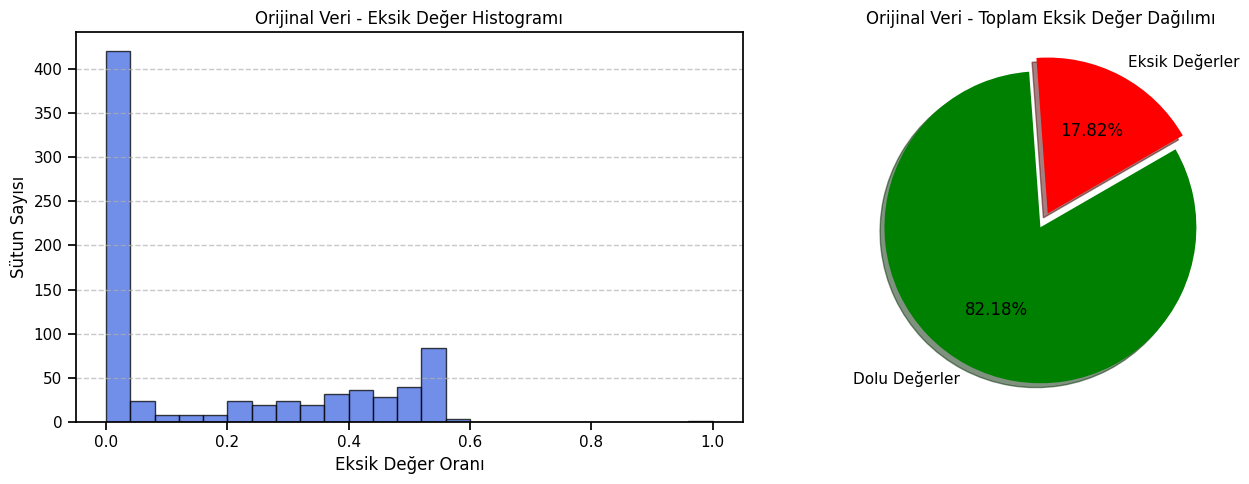

In [717]:
plot_missing_values(extracted_features_df, "Orijinal Veri")

**2. %40’TAN FAZLA EKSİK DEĞERİ OLAN SÜTUNLARI SİLME**

In [718]:
# Eksik değer oranlarını hesapla
nan_ratios = extracted_features_df.isnull().mean()

# %40’tan fazla eksik veriye sahip sütunları belirle ve sil
nan_threshold=0.4
cols_to_drop = nan_ratios[nan_ratios > nan_threshold].index
cleaned_data = extracted_features_df.drop(columns=cols_to_drop)

print(f"Silmeden önceki toplam sütun sayısı: {extracted_features_df.shape[1]}")
print(f"Silinen sütun sayısı: {len(cols_to_drop)}")
print(f"Yeni sütun sayısı: {cleaned_data.shape[1]}")

Silmeden önceki toplam sütun sayısı: 781
Silinen sütun sayısı: 193
Yeni sütun sayısı: 588


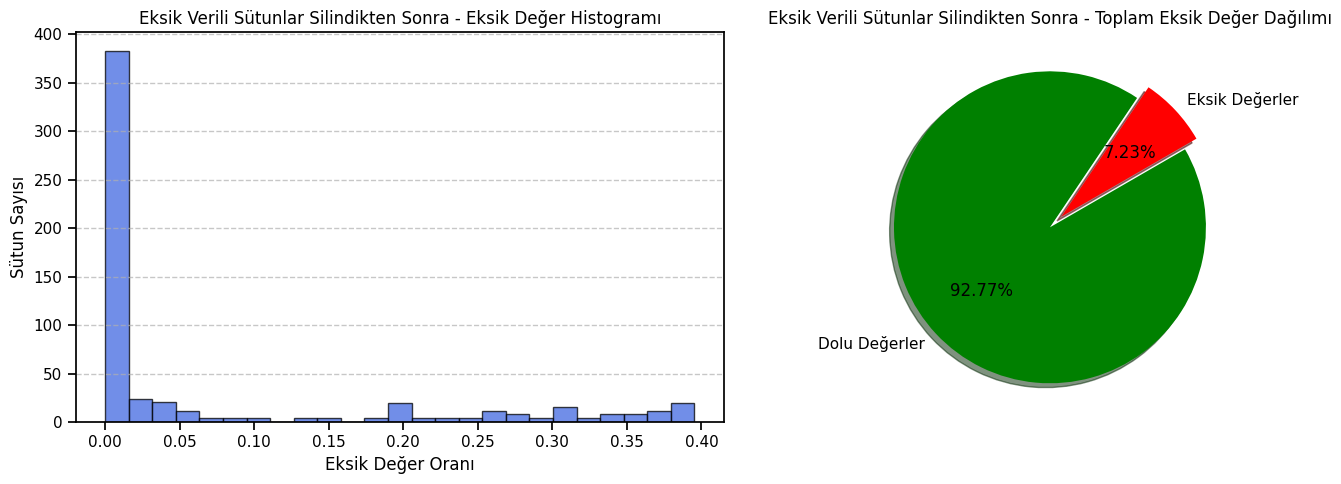

In [719]:
plot_missing_values(cleaned_data, "Eksik Verili Sütunlar Silindikten Sonra")

**3. KALAN EKSİK DEĞERLERİ MEDYAN İLE DOLDURMA**


In [720]:
from sklearn.impute import SimpleImputer

# Sayısal sütunları belirleme
numeric_cols = cleaned_data.select_dtypes(include=[np.number]).columns

# Eksik verileri doldurma 
imputer = SimpleImputer(strategy='median')
cleaned_data[numeric_cols] = imputer.fit_transform(cleaned_data[numeric_cols])
imputed_data = cleaned_data
imputed_data.isnull().mean()

Symbol                                            0.0
Close__variance_larger_than_standard_deviation    0.0
Close__has_duplicate_max                          0.0
Close__has_duplicate_min                          0.0
Close__has_duplicate                              0.0
                                                 ... 
Close__permutation_entropy__dimension_7__tau_1    0.0
Close__mean_n_absolute_max__number_of_maxima_7    0.0
Symbol_original                                   0.0
Sector                                            0.0
Sector_original                                   0.0
Length: 588, dtype: float64

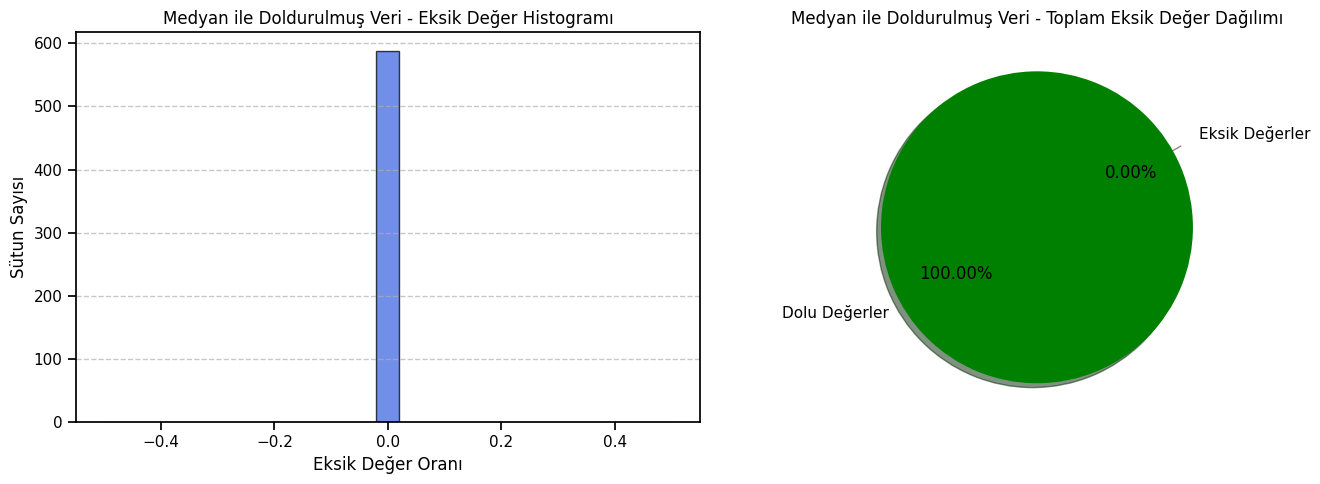

In [722]:
plot_missing_values(imputed_data, "Medyan ile Doldurulmuş Veri")

In [ ]:
imputed_data

,Symbol,Close__variance_larger_than_standard_deviation,Close__has_duplicate_max,Close__has_duplicate_min,Close__has_duplicate,Close__sum_values,Close__abs_energy,Close__mean_abs_change,Close__mean_change,Close__mean_second_derivative_central,...,Close__fourier_entropy__bins_100,Close__permutation_entropy__dimension_3__tau_1,Close__permutation_entropy__dimension_4__tau_1,Close__permutation_entropy__dimension_5__tau_1,Close__permutation_entropy__dimension_6__tau_1,Close__permutation_entropy__dimension_7__tau_1,Close__mean_n_absolute_max__number_of_maxima_7,Sector,Symbol_original,Sector_original
0,-1.584422,0.0,0.0,1.0,1.0,-267.113520,518.066569,0.103186,0.002004,0.000383,...,0.978607,1.621124,2.713357,3.619621,4.231608,4.544231,2.402853,0.0,HIVE,Financials
1,-1.529793,0.0,0.0,0.0,1.0,-101.888473,171.440060,0.126585,0.002517,0.001497,...,1.062604,1.669180,2.700753,3.417108,3.792708,3.955715,2.214819,0.0,BITF,Financials
2,-1.513214,0.0,0.0,0.0,1.0,-365.616934,569.422132,0.034148,0.002184,0.000118,...,0.581905,1.721892,2.946807,4.129425,4.853035,5.141245,2.146092,0.0,OXSQ,Financials
3,-1.493049,0.0,0.0,0.0,1.0,-68.102982,107.201492,0.081455,-0.027458,0.001983,...,1.638797,1.496745,2.407432,3.002610,3.159847,3.278750,1.772985,0.0,WDH,Financials
4,-1.261602,0.0,0.0,0.0,1.0,-304.978444,427.318001,0.072340,0.000296,-0.000114,...,0.380957,1.776521,3.080422,4.330990,5.144004,5.380670,1.776969,0.0,SIEB,Financials
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,3.677190,0.0,0.0,0.0,0.0,91.612786,195.208664,0.103232,-0.053623,-0.000688,...,0.854018,1.545391,2.444642,2.979006,3.308738,3.495746,2.274741,2.0,MAXN,Technology
2111,3.890813,0.0,0.0,0.0,1.0,456.745486,906.655554,0.075433,-0.013079,-0.001406,...,0.550193,1.751942,3.013465,4.269433,4.972583,5.279605,2.413388,2.0,RIME,Technology
2112,3.936097,1.0,0.0,0.0,1.0,175.300955,476.692617,0.097096,-0.051646,-0.001564,...,0.518718,1.436018,2.305248,3.042596,3.511221,3.819710,3.122316,2.0,FRGT,Technology
2113,4.251434,0.0,0.0,0.0,1.0,277.981650,735.532985,0.080527,-0.031343,-0.000432,...,0.438174,1.657965,2.753630,3.750939,4.273127,4.523633,3.132497,2.0,VERB,Technology


## 8.2. Pipeline

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np

missing_value_analysis = Pipeline([
    ('compute_missing_ratios', FunctionTransformer(lambda X: (X, X.isnull().mean()))), # boş değerlerin ortlamasnı hesaplama
    ('identify_high_missing_columns', FunctionTransformer(lambda X: (X[0], X[1][X[1] > 0.4].keys().to_list()))), # %40 tan fazla boş değere sahip sütunları belirleme
    ('drop_high_missing_columns', FunctionTransformer(lambda X: (X[0].drop(columns=X[1])))) # belirlenen sütunları kaldırma
])

numerical_imputer = ColumnTransformer(
    transformers=[
        ('median_imputer', SimpleImputer(strategy='median'), lambda X: X.select_dtypes(include=[np.number]).columns.tolist()) # geri kalan veri boş değerleri medyan ile doldurma
    ],
    remainder='passthrough', force_int_remainder_cols=False, verbose_feature_names_out=False
)

imputer_pipeline = Pipeline([
    ('missing_value_analysis', missing_value_analysis),
    ('numerical_imputation', numerical_imputer)
])


# Genel pipeline yapısına eklenecek kısım
imputer_general_pipeline = Pipeline([
    ('imputer', imputer_pipeline),
])

extracted_features_df = extracted_features.copy() # bir önceki bölümden gelen veri
imputed_data = imputer_general_pipeline.fit_transform(extracted_features_df)
imputed_data

,Symbol,Close__variance_larger_than_standard_deviation,Close__has_duplicate_max,Close__has_duplicate_min,Close__has_duplicate,Close__sum_values,Close__abs_energy,Close__mean_abs_change,Close__mean_change,Close__mean_second_derivative_central,...,Close__fourier_entropy__bins_100,Close__permutation_entropy__dimension_3__tau_1,Close__permutation_entropy__dimension_4__tau_1,Close__permutation_entropy__dimension_5__tau_1,Close__permutation_entropy__dimension_6__tau_1,Close__permutation_entropy__dimension_7__tau_1,Close__mean_n_absolute_max__number_of_maxima_7,Sector,Symbol_original,Sector_original
0,-1.584422,0.0,0.0,1.0,1.0,-267.113520,518.066569,0.103186,0.002004,0.000383,...,0.978607,1.621124,2.713357,3.619621,4.231608,4.544231,2.402853,0.0,HIVE,Financials
1,-1.529793,0.0,0.0,0.0,1.0,-101.888473,171.440060,0.126585,0.002517,0.001497,...,1.062604,1.669180,2.700753,3.417108,3.792708,3.955715,2.214819,0.0,BITF,Financials
2,-1.513214,0.0,0.0,0.0,1.0,-365.616934,569.422132,0.034148,0.002184,0.000118,...,0.581905,1.721892,2.946807,4.129425,4.853035,5.141245,2.146092,0.0,OXSQ,Financials
3,-1.493049,0.0,0.0,0.0,1.0,-68.102982,107.201492,0.081455,-0.027458,0.001983,...,1.638797,1.496745,2.407432,3.002610,3.159847,3.278750,1.772985,0.0,WDH,Financials
4,-1.261602,0.0,0.0,0.0,1.0,-304.978444,427.318001,0.072340,0.000296,-0.000114,...,0.380957,1.776521,3.080422,4.330990,5.144004,5.380670,1.776969,0.0,SIEB,Financials
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,3.677190,0.0,0.0,0.0,0.0,91.612786,195.208664,0.103232,-0.053623,-0.000688,...,0.854018,1.545391,2.444642,2.979006,3.308738,3.495746,2.274741,2.0,MAXN,Technology
2111,3.890813,0.0,0.0,0.0,1.0,456.745486,906.655554,0.075433,-0.013079,-0.001406,...,0.550193,1.751942,3.013465,4.269433,4.972583,5.279605,2.413388,2.0,RIME,Technology
2112,3.936097,1.0,0.0,0.0,1.0,175.300955,476.692617,0.097096,-0.051646,-0.001564,...,0.518718,1.436018,2.305248,3.042596,3.511221,3.819710,3.122316,2.0,FRGT,Technology
2113,4.251434,0.0,0.0,0.0,1.0,277.981650,735.532985,0.080527,-0.031343,-0.000432,...,0.438174,1.657965,2.753630,3.750939,4.273127,4.523633,3.132497,2.0,VERB,Technology


# 9. Özellik Seçme

## 9.1. Manuel İşlem

**Sabit Değerli Sütunları Kaldırma**

In [ ]:
from feature_engine.selection import DropConstantFeatures

imputed_df =imputed_data.copy() # bir önceki bölümden gelen veri
X=imputed_df.drop(["Symbol", "Symbol_original", "Sector", "Sector_original"],axis=1)
selector = DropConstantFeatures(tol=0.8)  
X = selector.fit_transform(X)
X

,Close__has_duplicate,Close__sum_values,Close__abs_energy,Close__mean_abs_change,Close__mean_change,Close__mean_second_derivative_central,Close__median,Close__mean,Close__length,Close__standard_deviation,...,Close__fourier_entropy__bins_3,Close__fourier_entropy__bins_5,Close__fourier_entropy__bins_10,Close__fourier_entropy__bins_100,Close__permutation_entropy__dimension_3__tau_1,Close__permutation_entropy__dimension_4__tau_1,Close__permutation_entropy__dimension_5__tau_1,Close__permutation_entropy__dimension_6__tau_1,Close__permutation_entropy__dimension_7__tau_1,Close__mean_n_absolute_max__number_of_maxima_7
0,1.0,-267.113520,518.066569,0.103186,0.002004,0.000383,-1.724413,-1.589961,168.0,0.745488,...,0.175154,0.238690,0.302082,0.978607,1.621124,2.713357,3.619621,4.231608,4.544231,2.402853
1,1.0,-101.888473,171.440060,0.126585,0.002517,0.001497,-1.595200,-1.543765,66.0,0.462998,...,0.264491,0.395372,0.525304,1.062604,1.669180,2.700753,3.417108,3.792708,3.955715,2.214819
2,1.0,-365.616934,569.422132,0.034148,0.002184,0.000118,-1.485051,-1.517083,241.0,0.247401,...,0.047865,0.095661,0.179587,0.581905,1.721892,2.946807,4.129425,4.853035,5.141245,2.146092
3,1.0,-68.102982,107.201492,0.081455,-0.027458,0.001983,-1.636773,-1.513400,45.0,0.303112,...,0.295439,0.642858,0.642858,1.638797,1.496745,2.407432,3.002610,3.159847,3.278750,1.772985
4,1.0,-304.978444,427.318001,0.072340,0.000296,-0.000114,-1.385169,-1.265471,241.0,0.414352,...,0.131930,0.168130,0.227173,0.380957,1.776521,3.080422,4.330990,5.144004,5.380670,1.776969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,0.0,91.612786,195.208664,0.103232,-0.053623,-0.000688,2.080248,1.696533,54.0,0.858342,...,0.306829,0.306829,0.458208,0.854018,1.545391,2.444642,2.979006,3.308738,3.495746,2.274741
2111,1.0,456.745486,906.655554,0.075433,-0.013079,-0.001406,2.019613,1.895209,241.0,0.412598,...,0.084204,0.143387,0.191044,0.550193,1.751942,3.013465,4.269433,4.972583,5.279605,2.413388
2112,1.0,175.300955,476.692617,0.097096,-0.051646,-0.001564,2.401307,1.947788,90.0,1.225849,...,0.208982,0.312737,0.312737,0.518718,1.436018,2.305248,3.042596,3.511221,3.819710,3.122316
2113,1.0,277.981650,735.532985,0.080527,-0.031343,-0.000432,2.587663,2.260013,123.0,0.933961,...,0.164865,0.164865,0.246897,0.438174,1.657965,2.753630,3.750939,4.273127,4.523633,3.132497


**Çok Fazla Tekrar Eden Sütunları Kaldırma**

In [726]:
from feature_engine.selection import DropDuplicateFeatures

selector = DropDuplicateFeatures()
X = selector.fit_transform(X)
X

,Close__has_duplicate,Close__sum_values,Close__abs_energy,Close__mean_abs_change,Close__mean_change,Close__mean_second_derivative_central,Close__median,Close__mean,Close__length,Close__standard_deviation,...,Close__fourier_entropy__bins_3,Close__fourier_entropy__bins_5,Close__fourier_entropy__bins_10,Close__fourier_entropy__bins_100,Close__permutation_entropy__dimension_3__tau_1,Close__permutation_entropy__dimension_4__tau_1,Close__permutation_entropy__dimension_5__tau_1,Close__permutation_entropy__dimension_6__tau_1,Close__permutation_entropy__dimension_7__tau_1,Close__mean_n_absolute_max__number_of_maxima_7
0,1.0,-267.113520,518.066569,0.103186,0.002004,0.000383,-1.724413,-1.589961,168.0,0.745488,...,0.175154,0.238690,0.302082,0.978607,1.621124,2.713357,3.619621,4.231608,4.544231,2.402853
1,1.0,-101.888473,171.440060,0.126585,0.002517,0.001497,-1.595200,-1.543765,66.0,0.462998,...,0.264491,0.395372,0.525304,1.062604,1.669180,2.700753,3.417108,3.792708,3.955715,2.214819
2,1.0,-365.616934,569.422132,0.034148,0.002184,0.000118,-1.485051,-1.517083,241.0,0.247401,...,0.047865,0.095661,0.179587,0.581905,1.721892,2.946807,4.129425,4.853035,5.141245,2.146092
3,1.0,-68.102982,107.201492,0.081455,-0.027458,0.001983,-1.636773,-1.513400,45.0,0.303112,...,0.295439,0.642858,0.642858,1.638797,1.496745,2.407432,3.002610,3.159847,3.278750,1.772985
4,1.0,-304.978444,427.318001,0.072340,0.000296,-0.000114,-1.385169,-1.265471,241.0,0.414352,...,0.131930,0.168130,0.227173,0.380957,1.776521,3.080422,4.330990,5.144004,5.380670,1.776969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,0.0,91.612786,195.208664,0.103232,-0.053623,-0.000688,2.080248,1.696533,54.0,0.858342,...,0.306829,0.306829,0.458208,0.854018,1.545391,2.444642,2.979006,3.308738,3.495746,2.274741
2111,1.0,456.745486,906.655554,0.075433,-0.013079,-0.001406,2.019613,1.895209,241.0,0.412598,...,0.084204,0.143387,0.191044,0.550193,1.751942,3.013465,4.269433,4.972583,5.279605,2.413388
2112,1.0,175.300955,476.692617,0.097096,-0.051646,-0.001564,2.401307,1.947788,90.0,1.225849,...,0.208982,0.312737,0.312737,0.518718,1.436018,2.305248,3.042596,3.511221,3.819710,3.122316
2113,1.0,277.981650,735.532985,0.080527,-0.031343,-0.000432,2.587663,2.260013,123.0,0.933961,...,0.164865,0.164865,0.246897,0.438174,1.657965,2.753630,3.750939,4.273127,4.523633,3.132497


**Sabit Değerli Sütunları Kaldırma**

In [727]:
from sklearn.feature_selection import VarianceThreshold

threshold = 0.05  
selector = VarianceThreshold(threshold=threshold)
X = selector.fit_transform(X)
X

,Close__has_duplicate,Close__sum_values,Close__abs_energy,Close__median,Close__mean,Close__length,Close__standard_deviation,Close__variation_coefficient,Close__variance,Close__skewness,...,Close__number_crossing_m__m_1,Close__count_above__t_0,Close__count_below__t_0,Close__fourier_entropy__bins_10,Close__fourier_entropy__bins_100,Close__permutation_entropy__dimension_4__tau_1,Close__permutation_entropy__dimension_5__tau_1,Close__permutation_entropy__dimension_6__tau_1,Close__permutation_entropy__dimension_7__tau_1,Close__mean_n_absolute_max__number_of_maxima_7
0,1.0,-267.113520,518.066569,-1.724413,-1.589961,168.0,0.745488,-0.468872,0.555752,0.636178,...,0.0,0.029762,0.970238,0.302082,0.978607,2.713357,3.619621,4.231608,4.544231,2.402853
1,1.0,-101.888473,171.440060,-1.595200,-1.543765,66.0,0.462998,-0.299915,0.214367,0.187247,...,0.0,0.000000,1.000000,0.525304,1.062604,2.700753,3.417108,3.792708,3.955715,2.214819
2,1.0,-365.616934,569.422132,-1.485051,-1.517083,241.0,0.247401,-0.163077,0.061207,-0.694059,...,0.0,0.000000,1.000000,0.179587,0.581905,2.946807,4.129425,4.853035,5.141245,2.146092
3,1.0,-68.102982,107.201492,-1.636773,-1.513400,45.0,0.303112,-0.200286,0.091877,1.616509,...,0.0,0.000000,1.000000,0.642858,1.638797,2.407432,3.002610,3.159847,3.278750,1.772985
4,1.0,-304.978444,427.318001,-1.385169,-1.265471,241.0,0.414352,-0.327429,0.171688,1.250067,...,0.0,0.000000,1.000000,0.227173,0.380957,3.080422,4.330990,5.144004,5.380670,1.776969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,0.0,91.612786,195.208664,2.080248,1.696533,54.0,0.858342,0.505939,0.736751,-1.916738,...,1.0,0.888889,0.111111,0.458208,0.854018,2.444642,2.979006,3.308738,3.495746,2.274741
2111,1.0,456.745486,906.655554,2.019613,1.895209,241.0,0.412598,0.217706,0.170237,-2.057911,...,1.0,0.995851,0.004149,0.191044,0.550193,3.013465,4.269433,4.972583,5.279605,2.413388
2112,1.0,175.300955,476.692617,2.401307,1.947788,90.0,1.225849,0.629354,1.502705,-1.647181,...,1.0,0.900000,0.100000,0.312737,0.518718,2.305248,3.042596,3.511221,3.819710,3.122316
2113,1.0,277.981650,735.532985,2.587663,2.260013,123.0,0.933961,0.413254,0.872282,-1.776515,...,1.0,0.951220,0.048780,0.246897,0.438174,2.753630,3.750939,4.273127,4.523633,3.132497


**Yüksek Korelasyonlu Sütunları Kaldırma**

In [728]:
from feature_engine.selection import DropCorrelatedFeatures

selector = DropCorrelatedFeatures(method='spearman', threshold=0.85)
X = selector.fit_transform(X)
X

,Close__has_duplicate,Close__abs_energy,Close__standard_deviation,Close__skewness,Close__kurtosis,Close__absolute_sum_of_changes,Close__count_above_mean,Close__count_below_mean,Close__first_location_of_maximum,Close__first_location_of_minimum,...,"Close__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","Close__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""mean""","Close__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""min""","Close__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""mean""","Close__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""","Close__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",Close__number_crossing_m__m_0,Close__number_crossing_m__m_-1,Close__number_crossing_m__m_1,Close__permutation_entropy__dimension_4__tau_1
0,1.0,518.066569,0.745488,0.636178,-0.744489,17.232048,73.0,95.0,0.720238,0.160714,...,-2.148394,-2.111957,0.360749,0.399544,0.321366,1.0,4.0,12.0,0.0,2.713357
1,1.0,171.440060,0.462998,0.187247,-0.983774,8.227996,31.0,35.0,0.409091,0.196970,...,-1.112610,-1.587583,0.505725,0.180749,0.000244,11.0,0.0,2.0,0.0,2.700753
2,1.0,569.422132,0.247401,-0.694059,-0.130948,8.195527,127.0,114.0,0.721992,0.203320,...,-1.760468,-1.787229,0.199704,0.139291,0.279230,6.0,0.0,0.0,0.0,2.946807
3,1.0,107.201492,0.303112,1.616509,2.353345,3.584042,14.0,31.0,0.000000,0.711111,...,-0.626363,-0.146819,0.216824,0.130876,0.008219,1.0,0.0,1.0,0.0,2.407432
4,1.0,427.318001,0.414352,1.250067,0.861050,17.361523,93.0,148.0,0.676349,0.547718,...,-1.349403,-1.416218,0.064805,0.072942,0.395359,1.0,0.0,6.0,0.0,3.080422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,0.0,195.208664,0.858342,-1.916738,2.285410,5.471302,40.0,14.0,0.092593,0.981481,...,2.793522,1.875142,-0.300765,-2.411218,0.929800,9.0,1.0,0.0,1.0,2.444642
2111,1.0,906.655554,0.412598,-2.057911,7.485992,18.103927,153.0,88.0,0.099585,0.995851,...,2.346123,2.038011,-0.385467,-0.078815,0.998352,8.0,1.0,0.0,1.0,3.013465
2112,1.0,476.692617,1.225849,-1.647181,1.920040,8.641513,62.0,28.0,0.033333,0.988889,...,3.491442,2.667016,-3.830970,-1.618262,1.000000,0.0,1.0,1.0,1.0,2.305248
2113,1.0,735.532985,0.933961,-1.776515,2.128735,9.824354,95.0,28.0,0.073171,0.991870,...,3.689928,3.093474,-1.492601,-1.151553,1.000000,0.0,1.0,0.0,1.0,2.753630


In [729]:
feature_selected_data = X.assign(Symbol=imputed_df["Symbol"], Symbol_original=imputed_df["Symbol_original"], Sector=imputed_df["Sector"], Sector_original=imputed_df["Sector_original"])
feature_selected_data

,Close__has_duplicate,Close__abs_energy,Close__standard_deviation,Close__skewness,Close__kurtosis,Close__absolute_sum_of_changes,Close__count_above_mean,Close__count_below_mean,Close__first_location_of_maximum,Close__first_location_of_minimum,...,"Close__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""","Close__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",Close__number_crossing_m__m_0,Close__number_crossing_m__m_-1,Close__number_crossing_m__m_1,Close__permutation_entropy__dimension_4__tau_1,Symbol,Symbol_original,Sector,Sector_original
0,1.0,518.066569,0.745488,0.636178,-0.744489,17.232048,73.0,95.0,0.720238,0.160714,...,0.321366,1.0,4.0,12.0,0.0,2.713357,-1.584422,HIVE,0.0,Financials
1,1.0,171.440060,0.462998,0.187247,-0.983774,8.227996,31.0,35.0,0.409091,0.196970,...,0.000244,11.0,0.0,2.0,0.0,2.700753,-1.529793,BITF,0.0,Financials
2,1.0,569.422132,0.247401,-0.694059,-0.130948,8.195527,127.0,114.0,0.721992,0.203320,...,0.279230,6.0,0.0,0.0,0.0,2.946807,-1.513214,OXSQ,0.0,Financials
3,1.0,107.201492,0.303112,1.616509,2.353345,3.584042,14.0,31.0,0.000000,0.711111,...,0.008219,1.0,0.0,1.0,0.0,2.407432,-1.493049,WDH,0.0,Financials
4,1.0,427.318001,0.414352,1.250067,0.861050,17.361523,93.0,148.0,0.676349,0.547718,...,0.395359,1.0,0.0,6.0,0.0,3.080422,-1.261602,SIEB,0.0,Financials
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,0.0,195.208664,0.858342,-1.916738,2.285410,5.471302,40.0,14.0,0.092593,0.981481,...,0.929800,9.0,1.0,0.0,1.0,2.444642,3.677190,MAXN,2.0,Technology
2111,1.0,906.655554,0.412598,-2.057911,7.485992,18.103927,153.0,88.0,0.099585,0.995851,...,0.998352,8.0,1.0,0.0,1.0,3.013465,3.890813,RIME,2.0,Technology
2112,1.0,476.692617,1.225849,-1.647181,1.920040,8.641513,62.0,28.0,0.033333,0.988889,...,1.000000,0.0,1.0,1.0,1.0,2.305248,3.936097,FRGT,2.0,Technology
2113,1.0,735.532985,0.933961,-1.776515,2.128735,9.824354,95.0,28.0,0.073171,0.991870,...,1.000000,0.0,1.0,0.0,1.0,2.753630,4.251434,VERB,2.0,Technology


## 9.2. Pipeline

In [ ]:
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


feature_selector=Pipeline([
    ('constant_var', DropConstantFeatures(tol=0.80)), # %80'den fazla aynı değere sahip sütunları kaldırma
    ('dublicated_var', DropDuplicateFeatures()), # Tekrar eden sütunları kaldırma
    ('variance_threshold', VarianceThreshold(threshold=0.05)),  # Düşük varyansa sahip sütunları kaldırma
    ('drop_correlated_features', DropCorrelatedFeatures(method='spearman', threshold=0.85)) # Yüksek korelasyona sahip sütunları kaldırma
])

selector_preprocessor = ColumnTransformer([
    ('feature_selection', feature_selector, lambda X: X.drop(columns=['Symbol', 'Symbol_original','Sector', 'Sector_original']).columns.to_list()),
], remainder='passthrough', force_int_remainder_cols=False, verbose_feature_names_out=False)


feature_selector_pipeline=Pipeline([
    ('feature_selector',selector_preprocessor)
])

# Genel pipeline yapısına eklenecek kısım
feature_selector_general_pipeline = Pipeline([
    ('feature_selector', feature_selector_pipeline),
])

imputed_df =imputed_data.copy() # bir önceki bölümden gelen veri
feature_selected_data = feature_selector_general_pipeline.fit_transform(imputed_df)
feature_selected_data

,Close__has_duplicate,Close__abs_energy,Close__standard_deviation,Close__skewness,Close__kurtosis,Close__absolute_sum_of_changes,Close__count_above_mean,Close__count_below_mean,Close__first_location_of_maximum,Close__first_location_of_minimum,...,"Close__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""","Close__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",Close__number_crossing_m__m_0,Close__number_crossing_m__m_-1,Close__number_crossing_m__m_1,Close__permutation_entropy__dimension_4__tau_1,Symbol,Sector,Symbol_original,Sector_original
0,1.0,518.066569,0.745488,0.636178,-0.744489,17.232048,73.0,95.0,0.720238,0.160714,...,0.321366,1.0,4.0,12.0,0.0,2.713357,-1.584422,0.0,HIVE,Financials
1,1.0,171.440060,0.462998,0.187247,-0.983774,8.227996,31.0,35.0,0.409091,0.196970,...,0.000244,11.0,0.0,2.0,0.0,2.700753,-1.529793,0.0,BITF,Financials
2,1.0,569.422132,0.247401,-0.694059,-0.130948,8.195527,127.0,114.0,0.721992,0.203320,...,0.279230,6.0,0.0,0.0,0.0,2.946807,-1.513214,0.0,OXSQ,Financials
3,1.0,107.201492,0.303112,1.616509,2.353345,3.584042,14.0,31.0,0.000000,0.711111,...,0.008219,1.0,0.0,1.0,0.0,2.407432,-1.493049,0.0,WDH,Financials
4,1.0,427.318001,0.414352,1.250067,0.861050,17.361523,93.0,148.0,0.676349,0.547718,...,0.395359,1.0,0.0,6.0,0.0,3.080422,-1.261602,0.0,SIEB,Financials
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,0.0,195.208664,0.858342,-1.916738,2.285410,5.471302,40.0,14.0,0.092593,0.981481,...,0.929800,9.0,1.0,0.0,1.0,2.444642,3.677190,2.0,MAXN,Technology
2111,1.0,906.655554,0.412598,-2.057911,7.485992,18.103927,153.0,88.0,0.099585,0.995851,...,0.998352,8.0,1.0,0.0,1.0,3.013465,3.890813,2.0,RIME,Technology
2112,1.0,476.692617,1.225849,-1.647181,1.920040,8.641513,62.0,28.0,0.033333,0.988889,...,1.000000,0.0,1.0,1.0,1.0,2.305248,3.936097,2.0,FRGT,Technology
2113,1.0,735.532985,0.933961,-1.776515,2.128735,9.824354,95.0,28.0,0.073171,0.991870,...,1.000000,0.0,1.0,0.0,1.0,2.753630,4.251434,2.0,VERB,Technology


# 10. Outlier Düzenleme

## 10.1. Manuel İşlem

**Winsorization**

Bu bölümde, aykırı değerleri daha stabil hale getirmek amacıyla Winsorization yöntemi tercih edilmiştir. Veri setinde her bir satır bir şirketi temsil ettiğinden, aykırı değerlerin doğrudan kaldırılması şirket verisinin kaybolmasına neden olabilir. Bu nedenle, veri kaybını önlemek için aykırı değerleri sınırlandıran Winsorization yöntemi kullanılmıştır.

In [ ]:
from feature_engine.outliers import Winsorizer

feature_selected_df = feature_selected_data.copy() # bir önceki bölümden gelen veri
feature_selected_df = feature_selected_df.drop(["Symbol","Symbol_original","Sector","Sector_original"], axis=1)
winsorizer = Winsorizer(capping_method='gaussian', tail='both', variables=None)  # Tüm sayısal sütunlara uygula
winsorize_outliers_data=winsorizer.fit_transform(feature_selected_df)
winsorize_outliers_data

,Close__has_duplicate,Close__abs_energy,Close__standard_deviation,Close__skewness,Close__kurtosis,Close__absolute_sum_of_changes,Close__count_above_mean,Close__count_below_mean,Close__first_location_of_maximum,Close__first_location_of_minimum,...,"Close__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","Close__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""mean""","Close__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""min""","Close__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""mean""","Close__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""","Close__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",Close__number_crossing_m__m_0,Close__number_crossing_m__m_-1,Close__number_crossing_m__m_1,Close__permutation_entropy__dimension_4__tau_1
0,1.0,475.997991,0.745488,0.636178,-0.744489,17.232048,73.0,95.0,0.720238,0.160714,...,-2.148394,-2.098222,0.360749,0.399544,0.321366,1.000000,4.0,12.0,0.0,2.713357
1,1.0,171.440060,0.462998,0.187247,-0.983774,8.227996,31.0,35.0,0.409091,0.196970,...,-1.112610,-1.587583,0.505725,0.180749,0.000244,11.000000,0.0,2.0,0.0,2.700753
2,1.0,475.997991,0.247401,-0.694059,-0.130948,8.195527,127.0,114.0,0.721992,0.203320,...,-1.760468,-1.787229,0.199704,0.139291,0.279230,6.000000,0.0,0.0,0.0,2.946807
3,1.0,107.201492,0.303112,1.616509,2.353345,3.584042,14.0,31.0,0.000000,0.711111,...,-0.626363,-0.146819,0.216824,0.130876,0.008219,1.000000,0.0,1.0,0.0,2.407432
4,1.0,427.318001,0.414352,1.250067,0.861050,17.361523,93.0,148.0,0.676349,0.547718,...,-1.349403,-1.416218,0.064805,0.072942,0.395359,1.000000,0.0,6.0,0.0,3.080422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,0.0,195.208664,0.858342,-1.916738,2.285410,5.471302,40.0,14.0,0.092593,0.981481,...,2.382172,1.790440,-0.300765,-1.113623,0.929800,9.000000,1.0,0.0,1.0,2.444642
2111,1.0,475.997991,0.412598,-1.982733,3.374995,18.103927,153.0,88.0,0.099585,0.995851,...,2.346123,1.790440,-0.385467,-0.078815,0.998352,8.000000,1.0,0.0,1.0,3.013465
2112,1.0,475.997991,1.100474,-1.647181,1.920040,8.641513,62.0,28.0,0.033333,0.988889,...,2.382172,1.790440,-0.957754,-1.113623,1.000000,0.000000,1.0,1.0,1.0,2.305248
2113,1.0,475.997991,0.933961,-1.776515,2.128735,9.824354,95.0,28.0,0.073171,0.991870,...,2.382172,1.790440,-0.957754,-1.113623,1.000000,0.000000,1.0,0.0,1.0,2.753630


In [732]:
winsorize_outliers_data = winsorize_outliers_data.assign(Symbol=feature_selected_data["Symbol"],
                                                         Symbol_original=feature_selected_data["Symbol"],
                                                         Sector=feature_selected_data["Sector"],
                                                         Sector_original=feature_selected_data["Sector_original"],)
winsorize_outliers_data

,Close__has_duplicate,Close__abs_energy,Close__standard_deviation,Close__skewness,Close__kurtosis,Close__absolute_sum_of_changes,Close__count_above_mean,Close__count_below_mean,Close__first_location_of_maximum,Close__first_location_of_minimum,...,"Close__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""","Close__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",Close__number_crossing_m__m_0,Close__number_crossing_m__m_-1,Close__number_crossing_m__m_1,Close__permutation_entropy__dimension_4__tau_1,Symbol,Symbol_original,Sector,Sector_original
0,1.0,475.997991,0.745488,0.636178,-0.744489,17.232048,73.0,95.0,0.720238,0.160714,...,0.321366,1.000000,4.0,12.0,0.0,2.713357,-1.584422,-1.584422,0.0,Financials
1,1.0,171.440060,0.462998,0.187247,-0.983774,8.227996,31.0,35.0,0.409091,0.196970,...,0.000244,11.000000,0.0,2.0,0.0,2.700753,-1.529793,-1.529793,0.0,Financials
2,1.0,475.997991,0.247401,-0.694059,-0.130948,8.195527,127.0,114.0,0.721992,0.203320,...,0.279230,6.000000,0.0,0.0,0.0,2.946807,-1.513214,-1.513214,0.0,Financials
3,1.0,107.201492,0.303112,1.616509,2.353345,3.584042,14.0,31.0,0.000000,0.711111,...,0.008219,1.000000,0.0,1.0,0.0,2.407432,-1.493049,-1.493049,0.0,Financials
4,1.0,427.318001,0.414352,1.250067,0.861050,17.361523,93.0,148.0,0.676349,0.547718,...,0.395359,1.000000,0.0,6.0,0.0,3.080422,-1.261602,-1.261602,0.0,Financials
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,0.0,195.208664,0.858342,-1.916738,2.285410,5.471302,40.0,14.0,0.092593,0.981481,...,0.929800,9.000000,1.0,0.0,1.0,2.444642,3.677190,3.677190,2.0,Technology
2111,1.0,475.997991,0.412598,-1.982733,3.374995,18.103927,153.0,88.0,0.099585,0.995851,...,0.998352,8.000000,1.0,0.0,1.0,3.013465,3.890813,3.890813,2.0,Technology
2112,1.0,475.997991,1.100474,-1.647181,1.920040,8.641513,62.0,28.0,0.033333,0.988889,...,1.000000,0.000000,1.0,1.0,1.0,2.305248,3.936097,3.936097,2.0,Technology
2113,1.0,475.997991,0.933961,-1.776515,2.128735,9.824354,95.0,28.0,0.073171,0.991870,...,1.000000,0.000000,1.0,0.0,1.0,2.753630,4.251434,4.251434,2.0,Technology


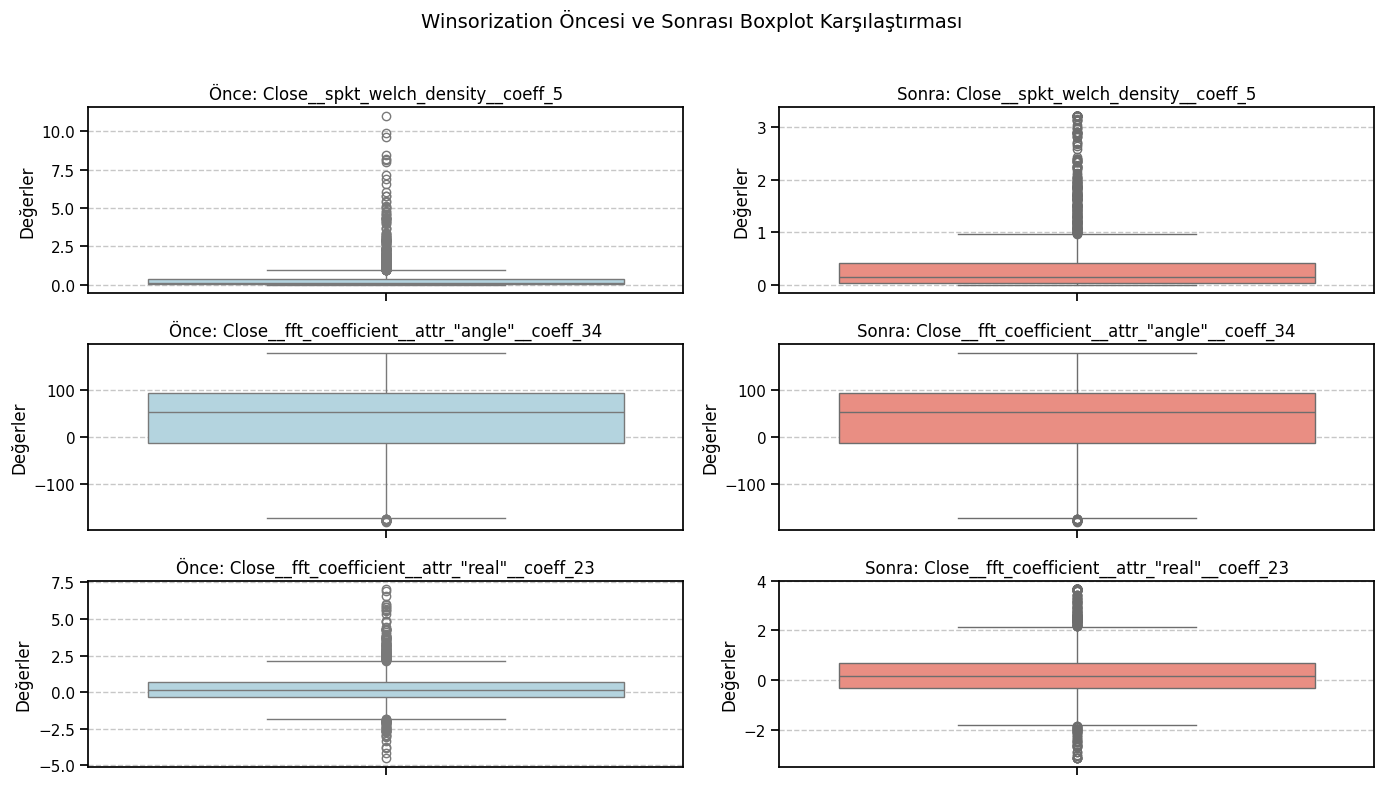

In [733]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

random_value = np.random.randint(10, len(feature_selected_df.columns), 3) # rastgele 3 sütun
fig, axes = plt.subplots(3, 2, figsize=(14, 8))  
plt.suptitle("Winsorization Öncesi ve Sonrası Boxplot Karşılaştırması", fontsize=14)
for i, value in enumerate(random_value):
    col = feature_selected_df.columns[value]
    sns.boxplot(y=feature_selected_df[col], ax=axes[i, 0], color="lightblue")
    axes[i, 0].set_title(f"Önce: {col}")
    axes[i, 0].set_ylabel("Değerler")
    axes[i, 0].grid(axis="y", linestyle="--", alpha=0.7)

    # Winsorized veri boxplot (Alt Satır)
    sns.boxplot(y=winsorize_outliers_data[col], ax=axes[i, 1], color="salmon")
    axes[i, 1].set_title(f"Sonra: {col}")
    axes[i, 1].set_ylabel("Değerler")
    axes[i, 1].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

## 10.2. Pipeline

In [ ]:
from feature_engine.outliers import Winsorizer
from sklearn.pipeline import Pipeline

outlier_capping = Pipeline([
    ('winsorizer', Winsorizer(capping_method='gaussian', tail='both', variables=None))
])

outlier_transformer = ColumnTransformer(
    transformers=[
        ('outlier_capping', outlier_capping, lambda X: X.drop(["Symbol","Symbol_original","Sector","Sector_original"], axis=1).columns.tolist())
    ],
    remainder='passthrough',  
    force_int_remainder_cols=False,
    verbose_feature_names_out=False
)

outlier_pipeline = Pipeline([
    ('outlier_processing', outlier_transformer)
])


# Genel pipeline yapısına eklenecek kısım
outlier_general_pipeline = Pipeline([
    ('outlier_pipeline', outlier_pipeline),
])

feature_selected_df = feature_selected_data.copy() # bir önceki bölümden gelen veri
winsorize_outliers_data = outlier_general_pipeline.fit_transform(feature_selected_df)
winsorize_outliers_data

,Close__has_duplicate,Close__abs_energy,Close__standard_deviation,Close__skewness,Close__kurtosis,Close__absolute_sum_of_changes,Close__count_above_mean,Close__count_below_mean,Close__first_location_of_maximum,Close__first_location_of_minimum,...,"Close__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""","Close__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",Close__number_crossing_m__m_0,Close__number_crossing_m__m_-1,Close__number_crossing_m__m_1,Close__permutation_entropy__dimension_4__tau_1,Symbol,Sector,Symbol_original,Sector_original
0,1.0,475.997991,0.745488,0.636178,-0.744489,17.232048,73.0,95.0,0.720238,0.160714,...,0.321366,1.000000,4.0,12.0,0.0,2.713357,-1.584422,0.0,HIVE,Financials
1,1.0,171.440060,0.462998,0.187247,-0.983774,8.227996,31.0,35.0,0.409091,0.196970,...,0.000244,11.000000,0.0,2.0,0.0,2.700753,-1.529793,0.0,BITF,Financials
2,1.0,475.997991,0.247401,-0.694059,-0.130948,8.195527,127.0,114.0,0.721992,0.203320,...,0.279230,6.000000,0.0,0.0,0.0,2.946807,-1.513214,0.0,OXSQ,Financials
3,1.0,107.201492,0.303112,1.616509,2.353345,3.584042,14.0,31.0,0.000000,0.711111,...,0.008219,1.000000,0.0,1.0,0.0,2.407432,-1.493049,0.0,WDH,Financials
4,1.0,427.318001,0.414352,1.250067,0.861050,17.361523,93.0,148.0,0.676349,0.547718,...,0.395359,1.000000,0.0,6.0,0.0,3.080422,-1.261602,0.0,SIEB,Financials
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,0.0,195.208664,0.858342,-1.916738,2.285410,5.471302,40.0,14.0,0.092593,0.981481,...,0.929800,9.000000,1.0,0.0,1.0,2.444642,3.677190,2.0,MAXN,Technology
2111,1.0,475.997991,0.412598,-1.982733,3.374995,18.103927,153.0,88.0,0.099585,0.995851,...,0.998352,8.000000,1.0,0.0,1.0,3.013465,3.890813,2.0,RIME,Technology
2112,1.0,475.997991,1.100474,-1.647181,1.920040,8.641513,62.0,28.0,0.033333,0.988889,...,1.000000,0.000000,1.0,1.0,1.0,2.305248,3.936097,2.0,FRGT,Technology
2113,1.0,475.997991,0.933961,-1.776515,2.128735,9.824354,95.0,28.0,0.073171,0.991870,...,1.000000,0.000000,1.0,0.0,1.0,2.753630,4.251434,2.0,VERB,Technology


# 11. Boyut İndirgeme

## 11.1. Manuel İşlem

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from umap import UMAP

winsorize_outliers_df = winsorize_outliers_data.copy() # bir önceki bölümden gelen veri
x = winsorize_outliers_df.drop(['Symbol_original','Sector', 'Sector_original'], axis=1)
y = winsorize_outliers_df['Sector']

def dimention_reduction(x,y):
    #PCA
    pca = PCA(n_components=2)
    x_pca = pca.fit_transform(x)

    #LDA
    lda = LinearDiscriminantAnalysis(n_components=2)
    x_lda = lda.fit_transform(x, y)

    #UMAP
    umap_mapper = UMAP(n_components=2, random_state=42)
    x_umap = umap_mapper.fit_transform(x)

    return x_pca, x_lda, x_umap

def visualization(x_pca, x_lda, x_umap, y):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
    plt.suptitle("Farklı Boyut İndirgeme Yöntemlerinin Sonuçları", fontsize=16)
    # PCA
    sns.scatterplot(x=x_pca.iloc[:, 0], y=x_pca.iloc[:, 1], hue=y, palette="tab10", alpha=0.7, ax=axes[0])
    axes[0].set_title("PCA (Principal Component Analysis)")
    axes[0].set_xlabel("Bileşen 1")
    axes[0].set_ylabel("Bileşen 2")
    axes[0].legend(loc="best", title="Sectors")  

    # LDA
    sns.scatterplot(x=x_lda.iloc[:, 0], y=x_lda.iloc[:, 1], hue=y, palette="tab10", alpha=0.7, ax=axes[1])
    axes[1].set_title("LDA (Linear Discriminant Analysis)")
    axes[1].set_xlabel("Ayrıştırıcı Bileşen 1")
    axes[1].set_ylabel("Ayrıştırıcı Bileşen 2")
    axes[1].legend(loc="best", title="Sectors") 

    # UMAP
    sns.scatterplot(x=x_umap[:, 0], y=x_umap[:, 1], hue=y, palette="tab10", alpha=0.7, ax=axes[2])
    axes[2].set_title("UMAP (Uniform Manifold Approximation)")
    axes[2].set_xlabel("Bileşen 1")
    axes[2].set_ylabel("Bileşen 2")
    axes[2].legend(loc="best", title="Sectors") 

    # Layout ayarı
    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

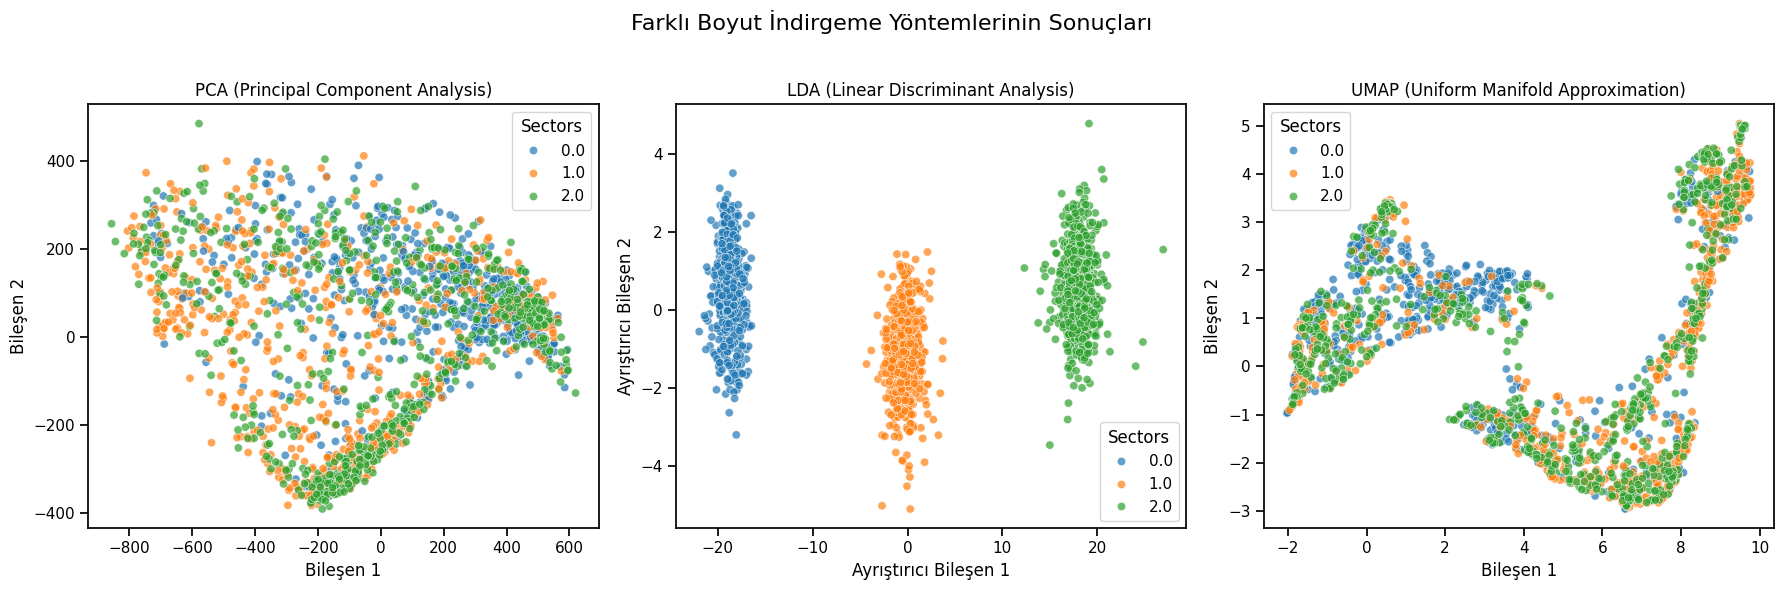

In [736]:
x_pca, x_lda, x_umap = dimention_reduction(x,y)
visualization(x_pca, x_lda, x_umap, y)

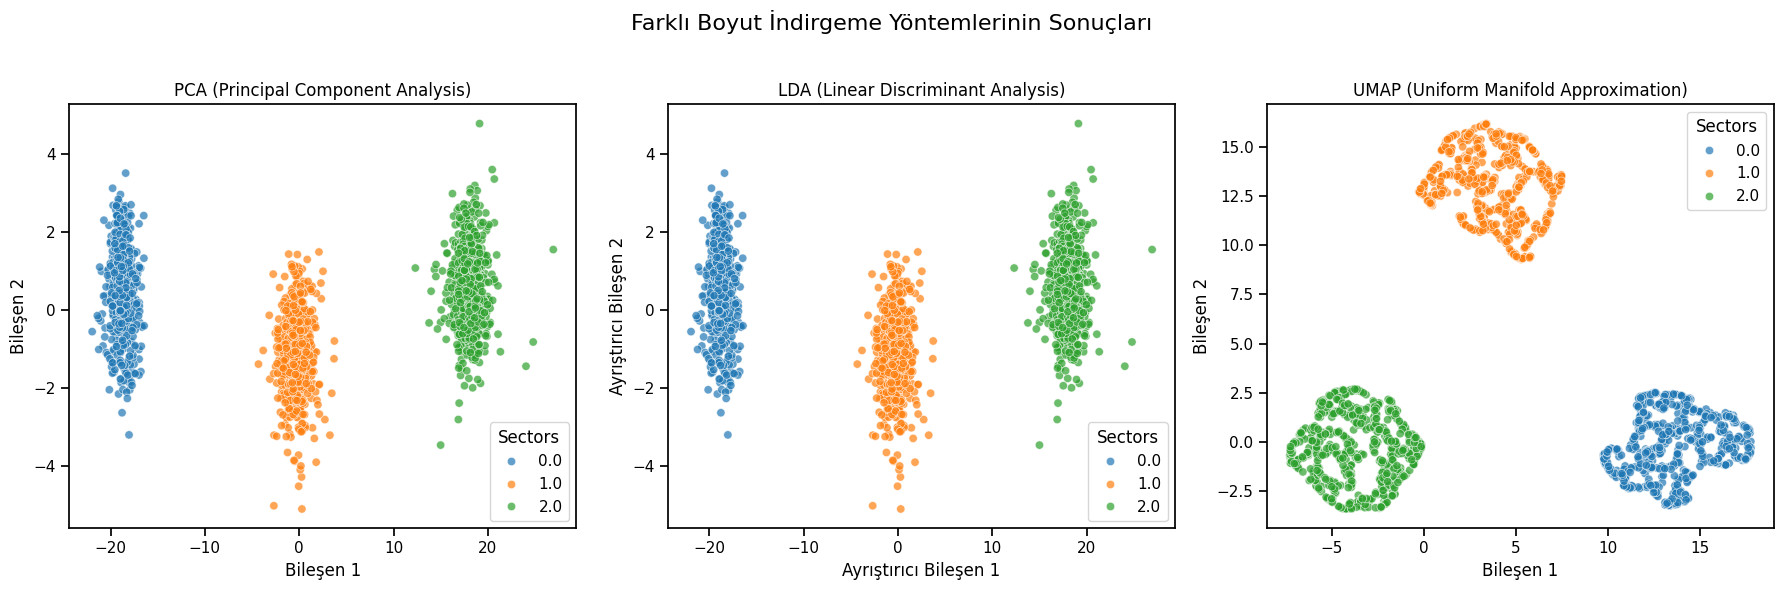

In [737]:
x_pca2, x_lda2, x_umap2 = dimention_reduction(x_lda,y)
visualization(x_pca2, x_lda2, x_umap2, y)

İlk aşamada elde edilen sonuçlar incelendiğinde, sınıflar arasındaki ayrımı en iyi sağlayan yöntemin LDA olduğu görülmüştür. Ancak, LDA ile elde edilen sonuçlar tekrar aynı işlemlere tabi tutulduğunda, UMAP yönteminin sınıfları daha düzenli bir şekilde kümelediği fark edilmiştir. Bu nedenle, iki aşamalı bir boyut indirgeme yöntemi tercih edilmiştir.

In [738]:
reducted_data = pd.DataFrame(x_umap2).assign(Symbol_original=winsorize_outliers_df["Symbol_original"],
                             Sector=winsorize_outliers_df["Sector"],
                             Sector_original=winsorize_outliers_df["Sector_original"])
reducted_data

,0,1,Symbol_original,Sector,Sector_original
0,11.941230,1.326005,HIVE,0.0,Financials
1,10.212195,-1.550903,BITF,0.0,Financials
2,17.656916,-0.718454,OXSQ,0.0,Financials
3,10.184978,-1.534943,WDH,0.0,Financials
4,11.694818,-1.187113,SIEB,0.0,Financials
...,...,...,...,...,...
2110,-6.611415,-0.748295,MAXN,2.0,Technology
2111,-2.332249,-3.289519,RIME,2.0,Technology
2112,-7.251226,-0.343078,FRGT,2.0,Technology
2113,-7.269557,-0.425780,VERB,2.0,Technology


## 11.2. Pipeline

Bu pipeline yapısı, projede kullanılacak eğitim ve test verilerinin farklı sektöre ait olmasından kaynaklanan özel bir formata sahiptir. İlk aşamada eğitim veri setine uygulanan yöntemin aynısının test verisi üzerinde de uygulanması hedeflenmektedir. Yani, eğitim verisinde öğrenilen özelliklerin test verisine de aktarılması gerekmektedir. Bu sebeple, eğitim veri seti üzerinde fit_transform işlemi yapılırken, test verisi üzerinde yalnızca transform işlemi uygulanmalıdır. Bu yaklaşım, eğitim verisinde öğrenilen dönüşümün test verisine de yansıtılmasını sağlar. Böylece, her iki veri seti de benzer işlemlerden geçerek tutarlı sonuçlar elde edilir. Yani burada kurgulanan yapı sayesinde tek bir pipeline üzerinden fit_transform ve transform işlemleri yapılabilmektedir.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from umap import UMAP
import pandas as pd

class DimReductionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lda_n=2, umap_n=2, random_state=42):
        self.lda = LinearDiscriminantAnalysis(n_components=lda_n)
        self.umap = UMAP(n_components=umap_n, random_state=random_state)

    def fit(self, X, y=None):
        X_features, y = X.drop(columns=['Sector', 'Symbol_original', 'Sector_original']), X['Sector']
        self.lda.fit(X_features, y)
        self.umap.fit(self.lda.transform(X_features))
        return self

    def transform(self, X):
        X_features = X.drop(columns=['Sector', 'Symbol_original', 'Sector_original'])
        X_transformed = self.umap.transform(self.lda.transform(X_features))
        return pd.DataFrame(X_transformed, columns=['Dim1', 'Dim2'], index=X.index).assign(
            Symbol_original=X['Symbol_original'].values,
            Sector=X['Sector'].values,
            Sector_original=X['Sector_original'].values
        )


# Genel pipeline yapısına eklenecek kısım
dim_reduct_general_pipeline = Pipeline([
    ('dimensionality_reduction',DimReductionTransformer())
])

winsorize_outliers_df = winsorize_outliers_data.copy() # bir önceki bölümden gelen veri
train_pipeline_data = dim_reduct_general_pipeline.fit_transform(winsorize_outliers_df)
train_pipeline_data

,Dim1,Dim2,Symbol_original,Sector,Sector_original
0,11.941230,1.326005,HIVE,0.0,Financials
1,10.212195,-1.550903,BITF,0.0,Financials
2,17.656916,-0.718454,OXSQ,0.0,Financials
3,10.184978,-1.534943,WDH,0.0,Financials
4,11.694818,-1.187113,SIEB,0.0,Financials
...,...,...,...,...,...
2110,-6.611415,-0.748295,MAXN,2.0,Technology
2111,-2.332249,-3.289519,RIME,2.0,Technology
2112,-7.251226,-0.343078,FRGT,2.0,Technology
2113,-7.269557,-0.425780,VERB,2.0,Technology


# 12. Genel Pipeline



Bu bölümde bu aşamaya kadar yapılan tüm veri işleme adımlarını içeren genel bir pipeline yapısı kurgulanmıştır. Bu sayede model için kullanılacak herhangi bir veri seti aşağıdaki pipeline yapısına verildği takdirde tek seferde model için hazır hale gelmektedir.

In [ ]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, PowerTransformer

from sklearn.preprocessing import RobustScaler

from category_encoders import CatBoostEncoder
from sklearn.preprocessing import LabelEncoder

from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh import extract_features

from sklearn.impute import SimpleImputer


from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import DropDuplicateFeatures
from sklearn.feature_selection import VarianceThreshold
from feature_engine.selection import DropCorrelatedFeatures

from feature_engine.outliers import Winsorizer

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn import set_config
set_config(transform_output="pandas")
import warnings
warnings.filterwarnings("ignore")


#####------ 1.Data Preprocessor ------#####
preprocessing_pipeline = Pipeline([
    ('drop_columns', FunctionTransformer(lambda X: X[["Date","Close","Symbol","Sector"]])), # kullanılmayacak sütunları kaldırma
    ('convert_date', FunctionTransformer(lambda X: X.assign(Date=pd.to_datetime(X["Date"])))), # tarih sütununu datetime formatına çevirme
    ('filter_symbols', FunctionTransformer(lambda X: X[X.groupby("Symbol")["Symbol"].transform("size") >= 11].reset_index(drop=True))), # 11 aydan daha az veriye sahip şirketleri kaldırma
])






#####------ 2.Transformer ------#####
transformer_pipeline = Pipeline([
    ('transformer', FunctionTransformer(lambda X: PowerTransformer(method='yeo-johnson').fit_transform(X))), 
])

transformer_preprocessor = ColumnTransformer([
    ('column_transformer', transformer_pipeline, lambda X: X.select_dtypes(include=[np.number]).columns.tolist()), # sadece sayısal değişkenlere uygulama
], remainder='passthrough', verbose_feature_names_out=False)






#####------ 3.Scaler ------#####
scaler_pipeline = Pipeline([
    ('scaler', RobustScaler()),
])

scaler_preprocessor = ColumnTransformer([
    ('column_scaler', scaler_pipeline, lambda X: X.select_dtypes(include=[np.number]).columns.tolist()),
], remainder='passthrough', verbose_feature_names_out=False)






#####------ 4.Encoder ------#####
encoder_pipeline = Pipeline([
    ('data_split', FunctionTransformer(lambda X: (
        X.drop(['Sector'], axis=1), # encode edilecek veri
        X['Sector'], # hedef değişken
        X # verinin kopyası   
    ))),

    ('label_encode', FunctionTransformer(lambda X: (
        X[0], # encode edilecek veri
        LabelEncoder().fit_transform(X[1]), # label encode edilmiş hedef değişken
        X[2] # verinin kopyası   
    ))),

    ('catboost_encode', FunctionTransformer(lambda X: (
        CatBoostEncoder(cols=["Symbol"])
        .fit(X[0], X[1])
        .transform(X[0]), # encode edilmiş veri
        X[1], # hedef değişken
        X[2] # verinin kopyası   
    ))),

    ('close_mean', FunctionTransformer(lambda X: (
        X[2].groupby("Symbol")["Close"].transform("mean"), # verinin kopyasından hesaplanan her bir şirkete ait ortalama Close değerleri
        X[0], # encode edilmiş veri 
        X[1], # hedef değişken
        X[2] # verinin kopyası
    ))),

    ('data_merge', FunctionTransformer(lambda X: 
        X[1].assign(
            Sector=X[2], 
            Symbol_original=X[3]["Symbol"], 
            Symbol=X[1]["Symbol"] + X[0], # encode edilmiş veri, hedef değişken ve ortalama Close değerlerini encode edilmiş veride bir araya getirme
            Sector_original = X[3]["Sector"]),
    )),

    ('column_design', FunctionTransformer(lambda X: 
        X[["Date", "Close", "Symbol", "Symbol_original", "Sector","Sector_original"]]
        .sort_values(by=["Symbol", "Date"])
        .reset_index(drop=True) # sütun sıralarını ve satır indekslerini düzenleme
    )),
])





#####------ 5.Feature-Extraction ------#####
feature_extract_pipeline = Pipeline([
    ('feature_extract', FunctionTransformer(lambda X: (
        extract_features(X, 
            column_id="Symbol", 
            column_sort="Date", 
            column_value="Close", 
            default_fc_parameters=EfficientFCParameters())
            .reset_index(names="Symbol"), # özellik çıkarılan veri
        X # orijinal veri
    ))),

    ('data_merge', FunctionTransformer(lambda X: (
        X[0]
        .merge(X[1][["Symbol", "Symbol_original", "Sector", "Sector_original"]].drop_duplicates(), 
               on="Symbol", 
               how="left") # Özellik çıkarma sırasında çıkarılan sütunları geri ekleme
    )))
])






#####------ 6.Imputing ------#####
missing_value_analysis = Pipeline([
    ('compute_missing_ratios', FunctionTransformer(lambda X: (X, X.isnull().mean()))), # boş değerlerin ortlamasnı hesaplama
    ('identify_high_missing_columns', FunctionTransformer(lambda X: (X[0], X[1][X[1] > 0.4].keys().to_list()))), # %40 tan fazla boş değere sahip sütunları belirleme
    ('drop_high_missing_columns', FunctionTransformer(lambda X: (X[0].drop(columns=X[1])))) # belirlenen sütunları kaldırma
])

numerical_imputer = ColumnTransformer(
    transformers=[
        ('median_imputer', SimpleImputer(strategy='median'), lambda X: X.select_dtypes(include=[np.number]).columns.tolist()) # geri kalan veri boş değerleri medyan ile doldurma
    ],
    remainder='passthrough', force_int_remainder_cols=False, verbose_feature_names_out=False
)

imputer_pipeline = Pipeline([
    ('missing_value_analysis', missing_value_analysis),
    ('numerical_imputation', numerical_imputer)
])






#####------ 7.Feature-Selection ------#####
feature_selector=Pipeline([
    ('constant_var', DropConstantFeatures(tol=0.80)), # %80'den fazla aynı değere sahip sütunları kaldırma
    ('dublicated_var', DropDuplicateFeatures()), # Tekrar eden sütunları kaldırma
    ('variance_threshold', VarianceThreshold(threshold=0.05)),  # Düşük varyansa sahip sütunları kaldırma
    ('drop_correlated_features', DropCorrelatedFeatures(method='spearman', threshold=0.85)) # Yüksek korelasyona sahip sütunları kaldırma
])

selector_preprocessor = ColumnTransformer([
    ('feature_selection', feature_selector, lambda X: X.drop(columns=['Symbol', 'Symbol_original', 'Sector', 'Sector_original']).columns.to_list()),
], remainder='passthrough', force_int_remainder_cols=False, verbose_feature_names_out=False)


feature_selector_pipeline=Pipeline([
    ('feature_selector',selector_preprocessor)
])






#####------ 8.Outlier-Handling ------#####
outlier_capping = Pipeline([
    ('winsorizer', Winsorizer(capping_method='gaussian', tail='both', variables=None))
])

outlier_transformer = ColumnTransformer(
    transformers=[
        ('outlier_capping', outlier_capping, lambda X: X.drop(["Symbol","Symbol_original","Sector","Sector_original"], axis=1).columns.tolist())
    ],
    remainder='passthrough',  
    force_int_remainder_cols=False,
    verbose_feature_names_out=False
)

outlier_pipeline = Pipeline([
    ('outlier_processing', outlier_transformer)
])







#####------ 9.Dimension-Reduction ------#####
class DimReductionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lda_n=2, umap_n=2, random_state=42):
        self.lda = LinearDiscriminantAnalysis(n_components=lda_n)
        self.umap = UMAP(n_components=umap_n, random_state=random_state)

    def fit(self, X, y=None):
        X_features, y = X.drop(columns=['Sector', 'Symbol_original', 'Sector_original']), X['Sector']
        self.lda.fit(X_features, y)
        self.umap.fit(self.lda.transform(X_features))
        return self

    def transform(self, X):
        X_features = X.drop(columns=['Sector', 'Symbol_original', 'Sector_original'])
        X_transformed = self.umap.transform(self.lda.transform(X_features))
        return pd.DataFrame(X_transformed, columns=['Dim1', 'Dim2'], index=X.index).assign(
            Symbol_original=X['Symbol_original'].values,
            Sector=X['Sector'].values,
            Sector_original=X['Sector_original'].values
        )







#####------ 10.Genel Pipeline ------#####
pipeline = Pipeline([
    ('data_preprocessing', preprocessing_pipeline),
    ('transformer', transformer_preprocessor),
    ('scaler', scaler_preprocessor),
    ('encoder', encoder_pipeline), 
    ('feature_extractor', feature_extract_pipeline), 
    ('imputer', imputer_pipeline),
    ('feature_selector', feature_selector_pipeline),
    ('outlier_pipeline', outlier_pipeline),
    ('dimensionality_reduction',DimReductionTransformer())
])

# 13. Eğitim 

In [ ]:
#2.bölümde elde edilen veri setini modele uygun hale getirme
train_data = pd.read_csv("all_data.csv", keep_default_na=False)
train_pipeline_data = pipeline.fit_transform(train_data)
train_pipeline_data

Feature Extraction: 100%|██████████| 40/40 [01:23<00:00,  2.09s/it]


,Dim1,Dim2,Symbol_original,Sector,Sector_original
0,11.941230,1.326005,HIVE,0.0,Financials
1,10.212195,-1.550903,BITF,0.0,Financials
2,17.656916,-0.718454,OXSQ,0.0,Financials
3,10.184978,-1.534943,WDH,0.0,Financials
4,11.694818,-1.187113,SIEB,0.0,Financials
...,...,...,...,...,...
2110,-6.611415,-0.748295,MAXN,2.0,Technology
2111,-2.332249,-3.289519,RIME,2.0,Technology
2112,-7.251226,-0.343078,FRGT,2.0,Technology
2113,-7.269557,-0.425780,VERB,2.0,Technology


In [750]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

# Veriyi hazırlama
X = train_pipeline_data.drop(["Sector",'Symbol_original','Sector_original'], axis=1)
y = train_pipeline_data["Sector"]


# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBClassifier": XGBClassifier(),
}

param_grid = {
    "Random Forest": {
        "n_estimators": [50, 100, 150, 200],   
        "max_depth": [3, 5, 10, None],           
        "min_samples_split": [2, 5, 10],         
        "min_samples_leaf": [1, 2, 4],           
        "max_features": ["auto", "sqrt", "log2"] 
    },
    
    "Gradient Boosting": {
        "n_estimators": [50, 100, 150, 200],  
        "learning_rate": [0.001, 0.01, 0.1],   
        "max_depth": [3, 5, 10, 15],             
        "subsample": [0.8, 0.9, 1.0],  
        "min_samples_split": [2, 5, 10]        
    },

    "XGBClassifier": {
        "n_estimators": [50, 100, 150, 200],   
        "learning_rate": [0.001, 0.01, 0.1],  
        "max_depth": [3, 5, 10, 15],             
        "subsample": [0.8, 0.9, 1.0],             
        "colsample_bytree": [0.7, 0.8, 1.0],     
        "gamma": [0, 0.1, 0.2, 0.3]              
    },
}

# GridSearchCV ve cross-validation sonuçlarını saklayacağız
grid_search_results = {}
test_scores = []
train_scores = []
best_models = {}


# Her bir model için işlem
for name, model in classifiers.items():
    # GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid[name], cv=5, n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    grid_search_results[name] = grid_search.best_params_
    best_models[name] = best_model


    # En iyi model ile tahminler
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    y_train_prob = best_model.predict_proba(X_train)
    y_test_prob = best_model.predict_proba(X_test)
    
    # Metrikleri hesaplama
    train_f1 = f1_score(y_train, y_train_pred, average="macro")
    test_f1 = f1_score(y_test, y_test_pred, average="macro")
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_roc_auc = roc_auc_score(y_train, y_train_prob, multi_class="ovr")
    test_roc_auc = roc_auc_score(y_test, y_test_prob, multi_class="ovr")

    # Sonuçları listeye ekleme
    train_scores.append({"Model": name, "Accuracy": train_acc, "F1 Score": train_f1, "ROC-AUC": train_roc_auc})
    test_scores.append({"Model": name, "Accuracy": test_acc, "F1 Score": test_f1, "ROC-AUC": test_roc_auc})

    # Classification report (Sınıflandırma raporu) 
    class_names = train_pipeline_data["Sector_original"].unique()
    print(f"{name} için Sınıflandırma Raporu:\n")
    print(classification_report(y_test, y_test_pred, target_names=class_names))
    print("-" * 80)

# Görselleştirmede kullanmak için DataFrame oluşturma
train_df = pd.DataFrame(train_scores)
test_df = pd.DataFrame(test_scores)

# GridSearchCV sonuçlarını yazdırma
print("GridSearchCV'e göre her modelin en iyi hiperparametreleri:")
for model_name, params in grid_search_results.items():
    print(f"{model_name}: {params}")

Random Forest için Sınıflandırma Raporu:

              precision    recall  f1-score   support

  Financials       1.00      1.00      1.00       144
  Healthcare       1.00      1.00      1.00       136
  Technology       1.00      1.00      1.00       143

    accuracy                           1.00       423
   macro avg       1.00      1.00      1.00       423
weighted avg       1.00      1.00      1.00       423

--------------------------------------------------------------------------------
Gradient Boosting için Sınıflandırma Raporu:

              precision    recall  f1-score   support

  Financials       1.00      1.00      1.00       144
  Healthcare       1.00      1.00      1.00       136
  Technology       1.00      1.00      1.00       143

    accuracy                           1.00       423
   macro avg       1.00      1.00      1.00       423
weighted avg       1.00      1.00      1.00       423

---------------------------------------------------------------------

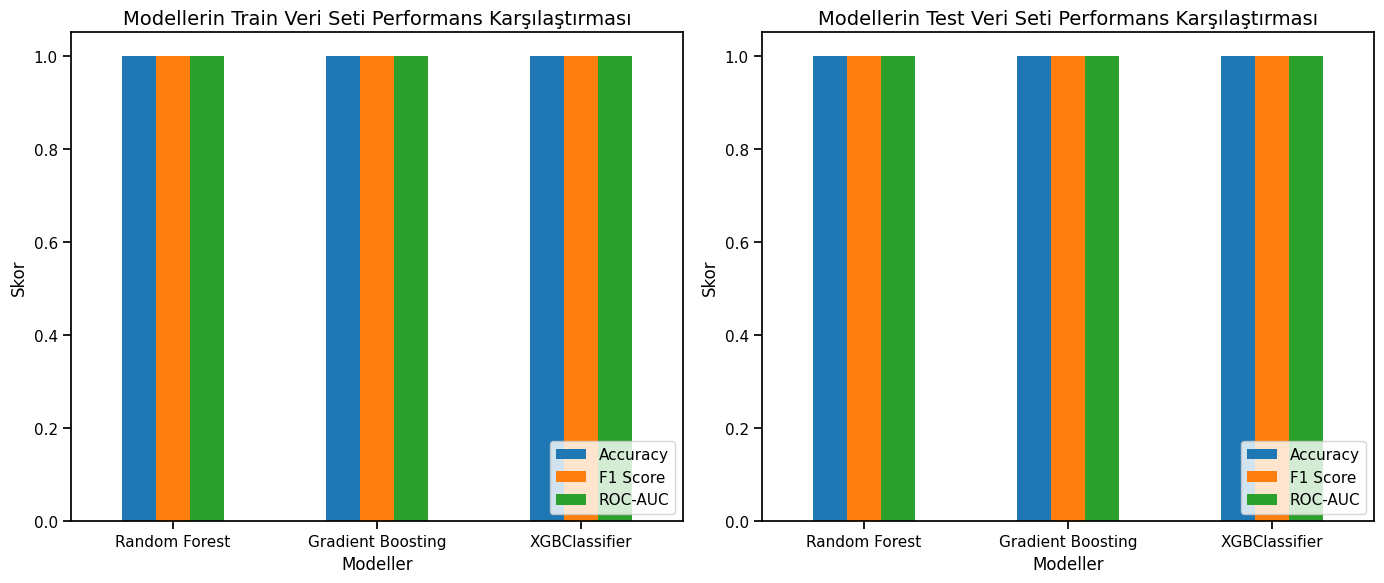

In [751]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
palette = sns.color_palette("tab10", len(class_names))

# Train 
train_df.set_index("Model").plot(kind="bar", ax=ax1, color=palette)
ax1.set_title("Modellerin Train Veri Seti Performans Karşılaştırması", fontsize=14)
ax1.set_xlabel("Modeller", fontsize=12)
ax1.set_ylabel("Skor", fontsize=12)
ax1.legend(loc="lower right")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha="center")  

# Test 
test_df.set_index("Model").plot(kind="bar", ax=ax2, color=palette)
ax2.set_title("Modellerin Test Veri Seti Performans Karşılaştırması", fontsize=14)
ax2.set_xlabel("Modeller", fontsize=12)
ax2.set_ylabel("Skor", fontsize=12)
ax2.legend(loc="lower right")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, ha="center") 

plt.tight_layout()
plt.show()

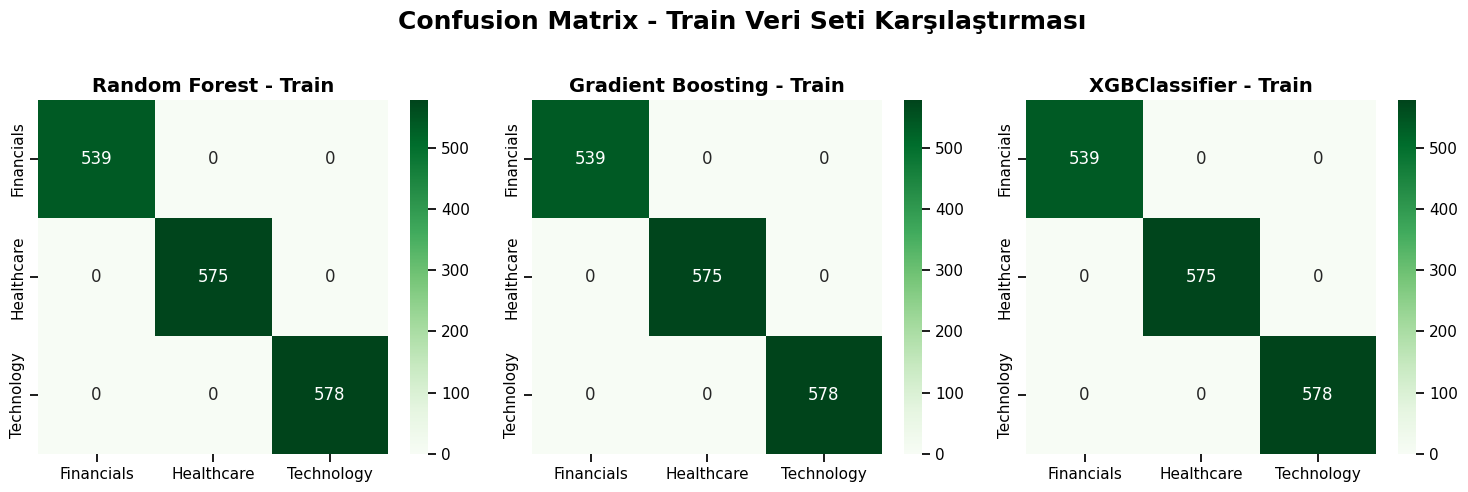

In [752]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

sector_labels = train_pipeline_data["Sector_original"].unique()
num_models = len(best_models)
figsize = (5 * num_models, 5) 
fig_test, axes_test = plt.subplots(1, num_models, figsize=figsize)
fig_test.suptitle("Confusion Matrix - Train Veri Seti Karşılaştırması", fontsize=18, fontweight="bold")
for ax, (name, model) in zip(axes_test, best_models.items()):
    y_pred = model.predict(X_train) 
    cm = confusion_matrix(y_train, y_pred)  
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
                xticklabels=sector_labels, yticklabels=sector_labels, ax=ax)
    ax.set_title(f"{name} - Train", fontsize=14, fontweight="bold")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
fig_test.subplots_adjust(top=0.80)
plt.show()

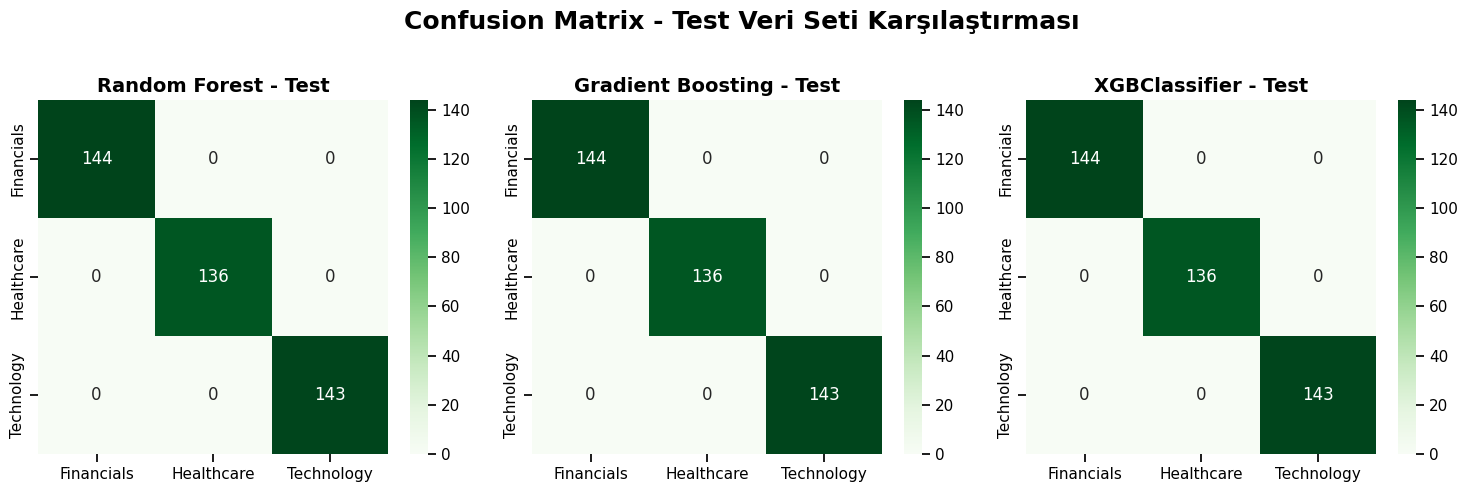

In [ ]:
num_models = len(best_models)
figsize = (5 * num_models, 5) 
fig_test, axes_test = plt.subplots(1, num_models, figsize=figsize)
fig_test.suptitle("Confusion Matrix - Test Veri Seti Karşılaştırması", fontsize=18, fontweight="bold")
for ax, (name, model) in zip(axes_test, best_models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred) 
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
                xticklabels=sector_labels, yticklabels=sector_labels, ax=ax)
    ax.set_title(f"{name} - Test", fontsize=14, fontweight="bold")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
fig_test.subplots_adjust(top=0.80)
plt.show()

In [754]:
best_model = grid_search.best_estimator_
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [755]:
import joblib

# En iyi modelin kaydedilmesi
joblib.dump(best_model, "best_model.pkl")

['best_model.pkl']


# 14. Sektörel Benzerlik Analizi

Bu bölümde, Real Estate sektöründeki şirket verileri elde edilip, eğitim verisine uygulanan tüm pipeline işlemleri bu verilere de uygulanarak, modelin bu verilere dayalı tahminler yapması sağlanmıştır. Yani, Real Estate sektörü özelindeki veriler, daha önce eğitimde kullanılan adımlarla aynı şekilde işlenip analiz edilmiştir ve sonuçlar üzerinden tahminler yapılmıştır.

**Real Estate sektörüne ait şirketleri seçme**

In [756]:
real_estate_companies = {}
df = pd.read_csv('./stock_sectors/real-estate.csv', keep_default_na=False)
selected_companies = df["Symbol"].tolist() 
real_estate_companies["Real Estate"] = selected_companies

print("Real Estate sektörüne ait seçilen şirket sayısı:\n")
for sec, comp in real_estate_companies.items():
    print(f"{sec}: {len(comp)} şirket seçildi.")

Real Estate sektörüne ait seçilen şirket sayısı:

Real Estate: 261 şirket seçildi.


**Seçilen şirketlerin elde edilmesi**

In [597]:
import time

all_data = pd.DataFrame()  # Tüm sektörlerden gelen verileri saklamak için boş DataFrame
count=0
for sector_name, stocks in real_estate_companies.items():
    for stock in stocks:  
        count+=1
        if count%100==0: # her 100 şirkette 5 saniye bekleme
            time.sleep(5)
        pre_data = fetch_yfinance_data(str(stock), sector_name)
        all_data = pd.concat([all_data, pre_data], ignore_index=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [598]:
all_data.to_csv("real_estate.csv", na_rep='NaN')

**Elde edilen şirketlerin sektörel benzerlik analizi**

In [757]:
test_data = pd.read_csv("real_estate.csv", keep_default_na=False)
test_data

,Unnamed: 0,Date,Close,High,Low,Open,Volume,Symbol,Sector
0,0,2005-01-01,19.215845,21.393951,18.942292,21.202980,9397200,PLD,Real Estate
1,1,2005-02-01,20.036505,20.593936,18.968098,19.226167,7605900,PLD,Real Estate
2,2,2005-03-01,19.510042,20.826195,18.849385,20.036504,7003900,PLD,Real Estate
3,3,2005-04-01,20.124247,20.211989,18.962935,19.510040,6079800,PLD,Real Estate
4,4,2005-05-01,21.050579,21.567573,20.126254,20.361252,5473400,PLD,Real Estate
...,...,...,...,...,...,...,...,...,...
41803,41803,2024-09-01,64.720001,298.799988,23.184000,25.920000,10720317,WHLR,Real Estate
41804,41804,2024-10-01,66.239998,150.479996,53.680000,63.520000,5294031,WHLR,Real Estate
41805,41805,2024-11-01,32.040001,79.040001,30.280001,66.160004,527628,WHLR,Real Estate
41806,41806,2024-12-01,13.480000,33.360001,13.200000,32.000000,4975850,WHLR,Real Estate


Eğitim verisine uygulanan tüm işlemlerin öğrenilmiş adımları **transform** aracılığıyla test verisine de uygulanmıştır. Bu sayede test verisinin de eğitim verisine benzemesi sağlanarak daha doğru sonuç elde edilmesi hedeflenmiştir.

In [759]:
test_pipeline_data = pipeline.transform(test_data)
test_pipeline_data

Feature Extraction: 100%|██████████| 37/37 [00:11<00:00,  3.19it/s]


,Dim1,Dim2,Symbol_original,Sector,Sector_original
0,11.582190,-0.838344,EQC,0.0,Real Estate
1,10.252546,-0.366804,LRHC,0.0,Real Estate
2,10.276795,-1.099737,OMH,0.0,Real Estate
3,10.336935,-1.476835,SQFT,0.0,Real Estate
4,13.060936,-3.181784,IHT,0.0,Real Estate
...,...,...,...,...,...
249,12.538935,1.796431,ALX,0.0,Real Estate
250,12.132092,2.474486,EQIX,0.0,Real Estate
251,10.827039,-2.268016,XHG,0.0,Real Estate
252,10.517298,-1.872927,AHT,0.0,Real Estate


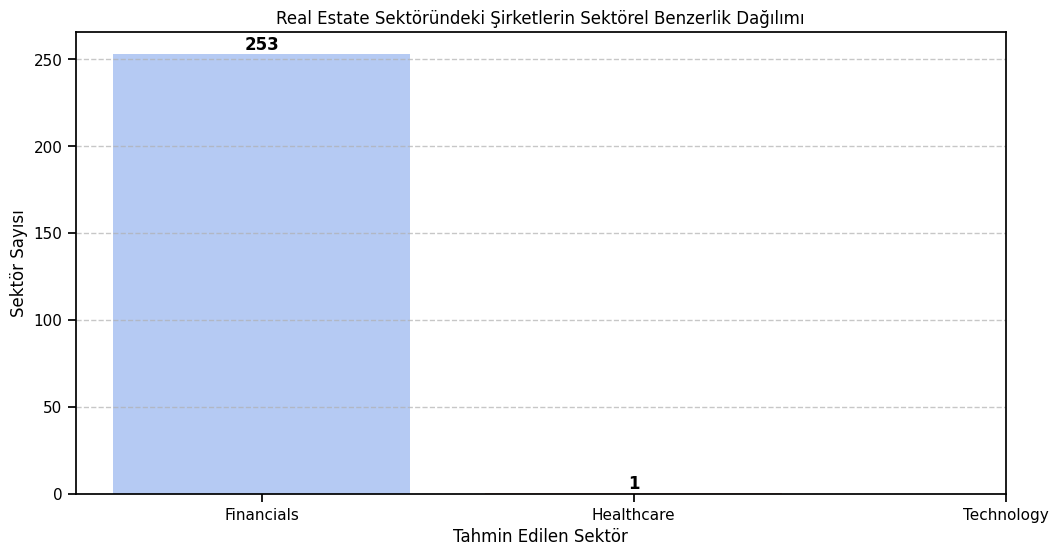

In [761]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# En iyi modelin yüklenmesi
best_model = joblib.load("best_model.pkl")

# Model tahminleri
predictions = best_model.predict(test_pipeline_data[["Dim1", "Dim2"]]).flatten()

# Tahminleri dataframe'e ekleme
prediction_results = pd.DataFrame({"Predicted_Label": predictions})

# Sektör isimleri
sector_labels = train_pipeline_data["Sector_original"].unique()
label_map = dict(enumerate(sector_labels))

# Çubuk grafiği çiz
plt.figure(figsize=(12, 6))
ax = sns.countplot(x=prediction_results["Predicted_Label"], palette="coolwarm")
plt.xticks(range(len(sector_labels)), [label_map[i] for i in range(len(sector_labels))])
plt.xlabel("Tahmin Edilen Sektör")
plt.ylabel("Sektör Sayısı")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.title("Real Estate Sektöründeki Şirketlerin Sektörel Benzerlik Dağılımı")

# Sayıları ekle
stocks_count = prediction_results["Predicted_Label"].value_counts().reset_index()
stocks_count.columns = ["Predicted_Label", "Company Count"]
for i, row in stocks_count.iterrows():
    ax.text(row["Predicted_Label"], row["Company Count"], 
            f'{row["Company Count"]}', ha='center', va='bottom', fontweight='bold')

plt.show()

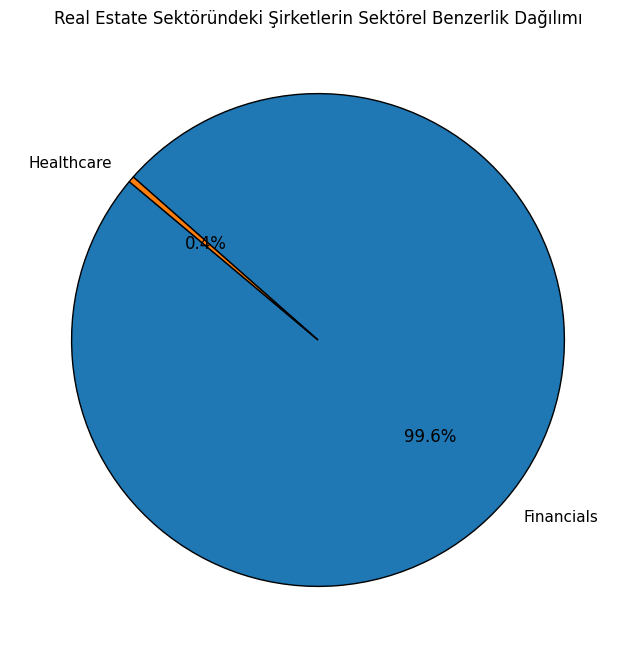

In [762]:
sector_counts = prediction_results["Predicted_Label"].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(sector_counts, labels=[label_map[cls] for cls in sector_counts.index], autopct="%1.1f%%", colors=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"], startangle=140, wedgeprops={"edgecolor": "k", "linewidth": 1})
plt.title("Real Estate Sektöründeki Şirketlerin Sektörel Benzerlik Dağılımı")
plt.show()

Elde edilen sonuçlar incelendiğinde Real Estate (emlak) sektörüne ait şirketlerin büyük çoğunluğunun Finans sektörüne benzerlik gösterdiği görülmektedir. Bunun nedeni araştırıldığında ise Real Estate şirketlerinin, genellikle yatırım, portföy yönetimi ve gayrimenkul finansmanı gibi faaliyetlerde yer aldığı ve bu nedenle davranış olarak daha çok finans sektörüne benzediği görülmektedir. Özellikle gayrimenkul yatırım fonları (REITs), mortgage ve emlak geliştirme şirketleri finansal araçlarla sıkça ilişkilidir ve bu sektöre ait zaman serisi verileri, genellikle piyasa koşullarına ve finansal performansa dayanmaktadır. Dolayısıyla Finans sektörüne daha benzer olmaları normal bir durum olarak görülmektedir.